In [152]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [153]:
fees = pd.read_csv('./data/extract - fees - data analyst - .csv')
cash_request = pd.read_csv('./data/extract - cash request - data analyst.csv')

In [154]:
corr_df = fees.merge(
    cash_request, left_on="cash_request_id", right_on="id", suffixes=("_fees", "_cash")
)

In [155]:
corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_fees                     21057 non-null  int64  
 1   cash_request_id             21057 non-null  float64
 2   type                        21057 non-null  object 
 3   status_fees                 21057 non-null  object 
 4   category                    2196 non-null   object 
 5   total_amount                21057 non-null  float64
 6   reason                      21057 non-null  object 
 7   created_at_fees             21057 non-null  object 
 8   updated_at_fees             21057 non-null  object 
 9   paid_at                     15531 non-null  object 
 10  from_date                   7766 non-null   object 
 11  to_date                     7766 non-null   object 
 12  charge_moment               21057 non-null  object 
 13  id_cash                     210

In [156]:
# create a categorical field for the 
corr_df['fees_rejeted'] = corr_df.groupby('cash_request_id')['category'].count()
corr_df['fees_rejeted']= corr_df['fees_rejeted'].fillna(0)
corr_df['fees_rejeted']=corr_df['fees_rejeted'].sort_values()
corr_df['fees_rejeted'].unique()
bins = [0 ,2, 5]
labels =['Low' , 'High']
corr_df['fees_rejection_segment'] = pd.cut(corr_df['fees_rejeted'] , bins = bins , labels = labels, include_lowest = True  )

In [157]:
# Filter dataset to only work on the paid credits to find anomalies
corr_df = corr_df[~corr_df['status_cash'].isin(['cancelled', 'rejected'])]

In [158]:
# Create a new feature: repayment delay in days
corr_df['money_back_date'] = pd.to_datetime(corr_df['money_back_date'], errors='coerce')
corr_df["reimbursement_date"] = pd.to_datetime(corr_df["reimbursement_date"], errors='coerce')
corr_df["repayment_delay"] = (corr_df["money_back_date"] - corr_df["reimbursement_date"]).dt.days

In [159]:
# Define segmentation based on repayment behavior
def categorize_repayment(row):
    '''
         "Defaulter" refers to a customer who has not repaid the money at all
         "Late Payer" refers to a customer who returned the money after the expected reimbursement date.
    '''
    if pd.isna(row["money_back_date"]):
        return "Defaulter"
    elif row["money_back_date"] <= row["reimbursement_date"]:
        return "On-time Payer"
    else:
        return "Late Payer"

In [160]:
corr_df["Repayment_Status"] = corr_df.apply(categorize_repayment, axis=1)

In [161]:
# Set the repayment_delay to -1 when we couldn't calculate it. 
corr_df["repayment_delay"].fillna(90, inplace=True)

date_cols = ["reimbursement_date", "paid_at" ,"created_at_fees", "cash_request_received_date" , "money_back_date" , "send_at", "reco_creation","reco_last_update"]
for col in date_cols:
    corr_df[col] = pd.to_datetime(corr_df[col], errors='coerce')
    corr_df[col]= corr_df[col].dt.tz_localize(None)
    corr_df[str(col)+'_Month']= corr_df[col].dt.to_period('M')
    corr_df=corr_df.drop(columns=[col])

corr_df.describe()

id_fees  cash_request_id  total_amount       id_cash  \
count  21057.000000     21057.000000  21057.000000  21057.000000   
mean   10646.670228     16318.449162      5.000237  16318.449162   
std     6099.136169      6656.149949      0.034457   6656.149949   
min        1.000000      1456.000000      5.000000   1456.000000   
25%     5388.000000     11745.000000      5.000000  11745.000000   
50%    10654.000000     17160.000000      5.000000  17160.000000   
75%    15926.000000     21796.000000      5.000000  21796.000000   
max    21193.000000     27010.000000     10.000000  27010.000000   

             amount        user_id  deleted_account_id  fees_rejeted  \
count  21057.000000   20151.000000          906.000000  21057.000000   
mean      81.833547   37988.603940        17334.621413      0.104051   
std       26.945058   27987.123692         7315.152519      0.422185   
min        1.000000      47.000000         3857.000000      0.000000   
25%       50.000000   14868.000000        11051.000000      0.000000   
50%      100.000000   31538.000000        19717.000000      0.000000   
75%      100.000000   56357.500000        23322.000000      0.000000   
max      200.000000  103503.000000        30445.000000      5.000000   

       repayment_delay  
count     21057.000000  
mean         73.607162  
std          33.706038  
min         -69.000000  
25%          90.000000  
50%          90.000000  
75%          90.000000  
max         161.000000

In [162]:
corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype    
---  ------                            --------------  -----    
 0   id_fees                           21057 non-null  int64    
 1   cash_request_id                   21057 non-null  float64  
 2   type                              21057 non-null  object   
 3   status_fees                       21057 non-null  object   
 4   category                          2196 non-null   object   
 5   total_amount                      21057 non-null  float64  
 6   reason                            21057 non-null  object   
 7   updated_at_fees                   21057 non-null  object   
 8   from_date                         7766 non-null   object   
 9   to_date                           7766 non-null   object   
 10  charge_moment                     21057 non-null  object   
 11  id_cash                           21057 n

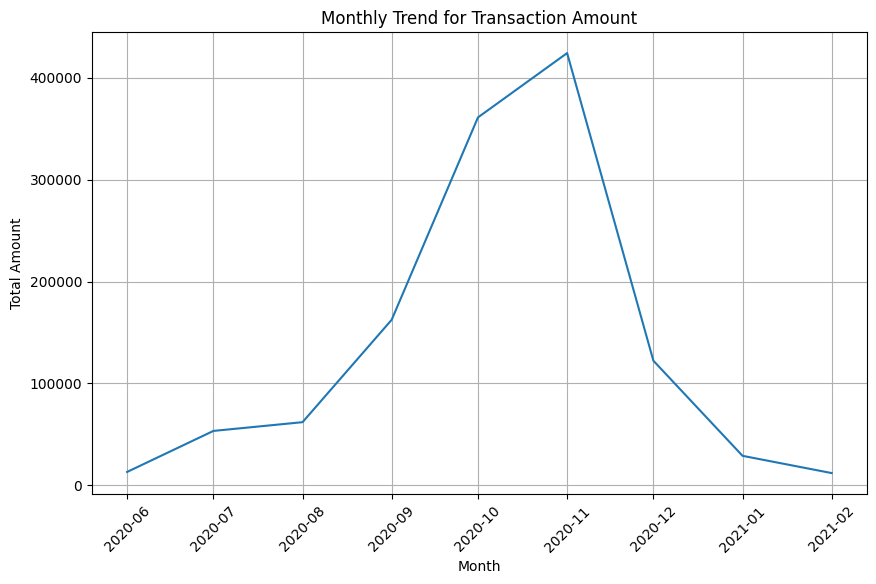

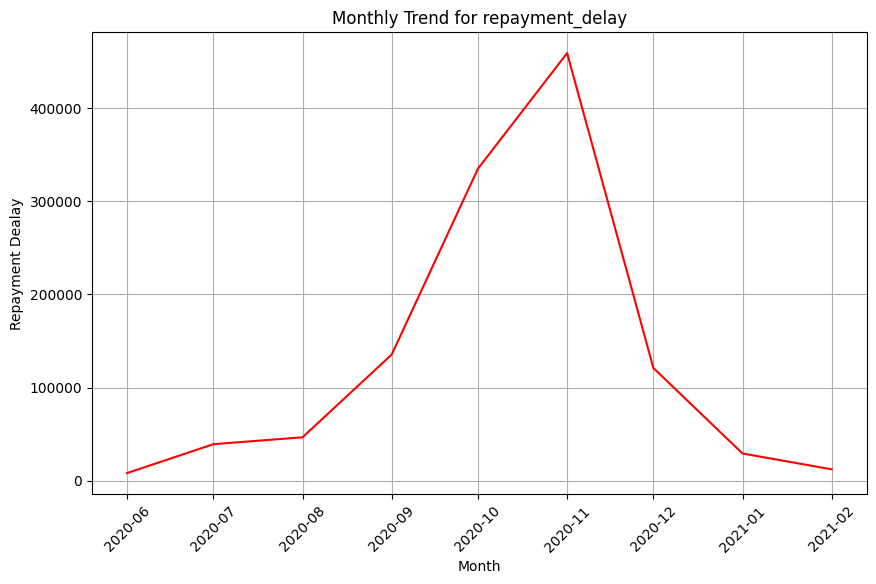

In [163]:
monthly_trend_for_transactions=corr_df.groupby( ['paid_at_Month'])[['amount', 'repayment_delay']].sum().reset_index()

monthly_trend_for_transactions['paid_at_Month'] = monthly_trend_for_transactions['paid_at_Month'].dt.to_timestamp()
monthly_trend_for_transactions = monthly_trend_for_transactions.sort_values(by='paid_at_Month')


plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trend_for_transactions, x='paid_at_Month', y='amount')

plt.title('Monthly Trend for Transaction Amount')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trend_for_transactions, x='paid_at_Month', y='repayment_delay' , color='red')

plt.title('Monthly Trend for repayment_delay')
plt.xlabel('Month')
plt.ylabel('Repayment Dealay')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

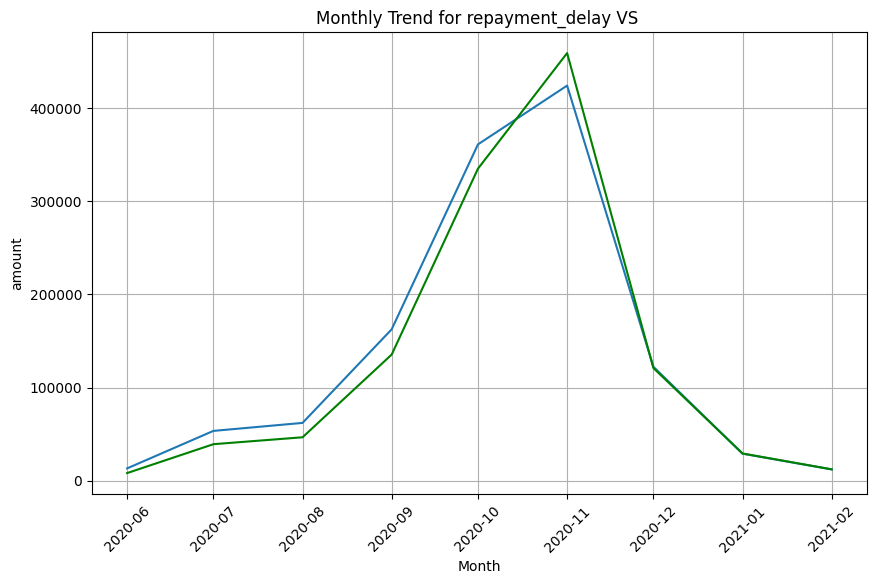

In [164]:
monthly_trend_for_repayment_delay=corr_df.groupby( ['paid_at_Month'])['repayment_delay'].sum().reset_index()

monthly_trend_for_repayment_delay['paid_at_Month'] = monthly_trend_for_repayment_delay['paid_at_Month'].dt.to_timestamp()
monthly_trend_for_repayment_delay = monthly_trend_for_repayment_delay.sort_values(by='paid_at_Month')

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trend_for_transactions, x='paid_at_Month', y='amount')
sns.lineplot(data=monthly_trend_for_repayment_delay, x='paid_at_Month', y='repayment_delay' , color='green')

plt.title('Monthly Trend for repayment_delay VS ')
plt.xlabel('Month')
# plt.ylabel()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

In [165]:
corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype    
---  ------                            --------------  -----    
 0   id_fees                           21057 non-null  int64    
 1   cash_request_id                   21057 non-null  float64  
 2   type                              21057 non-null  object   
 3   status_fees                       21057 non-null  object   
 4   category                          2196 non-null   object   
 5   total_amount                      21057 non-null  float64  
 6   reason                            21057 non-null  object   
 7   updated_at_fees                   21057 non-null  object   
 8   from_date                         7766 non-null   object   
 9   to_date                           7766 non-null   object   
 10  charge_moment                     21057 non-null  object   
 11  id_cash                           21057 n

In [166]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
# Select features for anomaly detection
label_encoder = LabelEncoder()
corr_df['type_encoded']= label_encoder.fit_transform(corr_df['type'])
corr_df['fees_rejection_segment_encoded'] = label_encoder.fit_transform(corr_df['fees_rejection_segment'])
corr_df['transfer_type_encoded']= label_encoder.fit_transform(corr_df['transfer_type'])
corr_df['status_fees_encoded']= label_encoder.fit_transform(corr_df['status_fees'])
features = ['total_amount', 'amount', 'repayment_delay' , 'type_encoded' , 'transfer_type_encoded' , 'status_fees_encoded', 'fees_rejection_segment_encoded']
corr_df.dropna(subset=features, inplace=True)
X = corr_df[features]

# Train Isolation Forest for anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
corr_df["Anomaly_Score"] = iso_forest.fit_predict(X)

# Label anomalies (-1 means an anomaly)
corr_df["Anomaly"] = corr_df["Anomaly_Score"].apply(lambda x: "Anomalous" if x == -1 else "Normal")

# Display the segmented data with anomaly detection
corr_df.head()

id_fees  cash_request_id             type status_fees  \
0     6537          14941.0  instant_payment    rejected   
1     6961          11714.0         incident    accepted   
2    16296          23371.0  instant_payment    accepted   
3    20775          26772.0  instant_payment    accepted   
4    11242          19350.0  instant_payment    accepted   

                category  total_amount                              reason  \
0                    NaN           5.0  Instant Payment Cash Request 14941   
1  rejected_direct_debit           5.0               rejected direct debit   
2                    NaN           5.0  Instant Payment Cash Request 23371   
3                    NaN           5.0  Instant Payment Cash Request 26772   
4                    NaN           5.0  Instant Payment Cash Request 19350   

                 updated_at_fees from_date to_date  ... money_back_date_Month  \
0  2020-10-13 14:25:09.396112+00       NaN     NaN  ...               2020-10   
1  2020-10-13 14:25:15.537063+00       NaN     NaN  ...                   NaT   
2  2020-10-23 10:10:58.352994+00       NaN     NaN  ...                   NaT   
3  2020-10-31 15:46:53.643982+00       NaN     NaN  ...               2020-11   
4  2020-10-13 14:25:03.267983+00       NaN     NaN  ...                   NaT   

   send_at_Month  reco_creation_Month reco_last_update_Month type_encoded  \
0        2020-09              2020-10                2020-12            1   
1        2020-08              2020-09                2020-10            0   
2        2020-10                  NaT                    NaT            1   
3        2020-10                  NaT                    NaT            1   
4        2020-10              2020-10                2020-11            1   

  fees_rejection_segment_encoded  transfer_type_encoded status_fees_encoded  \
0                              1                      0                   3   
1                              1                      0                   0   
2                              1                      0                   0   
3                              1                      0                   0   
4                              1                      0                   0   

   Anomaly_Score    Anomaly  
0             -1  Anomalous  
1              1     Normal  
2              1     Normal  
3              1     Normal  
4              1     Normal  

[5 rows x 39 columns]

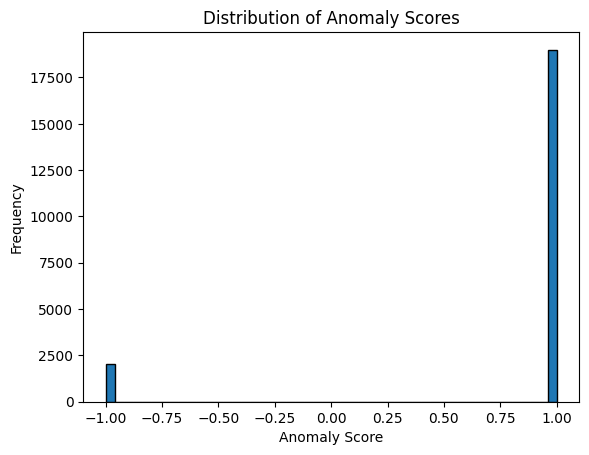

In [167]:
import matplotlib.pyplot as plt

plt.hist(corr_df["Anomaly_Score"], bins=50, edgecolor='black')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

In [168]:
print(corr_df["Anomaly"].value_counts(normalize=True) * 100)

Anomaly
Normal       90.221779
Anomalous     9.778221
Name: proportion, dtype: float64


In [169]:
anomalies = corr_df[corr_df["Anomaly"] == "Anomalous"]
anomalies[["cash_request_id", "total_amount", "repayment_delay", "Repayment_Status", "status_fees" , 'fees_rejection_segment']]

cash_request_id  total_amount  repayment_delay Repayment_Status  \
0              14941.0           5.0              5.0       Late Payer   
27             10287.0           5.0             90.0        Defaulter   
42             25769.0           5.0             90.0        Defaulter   
43             19981.0           5.0             90.0        Defaulter   
47              9338.0           5.0             90.0       Late Payer   
...                ...           ...              ...              ...   
21049          17642.0           5.0             90.0        Defaulter   
21052          20262.0           5.0              6.0       Late Payer   
21053          26764.0           5.0             90.0        Defaulter   
21054          25331.0           5.0             90.0        Defaulter   
21055          23628.0           5.0             90.0        Defaulter   

      status_fees fees_rejection_segment  
0        rejected                    Low  
27       rejected                    Low  
42       rejected                    Low  
43       rejected                    Low  
47       accepted                    Low  
...           ...                    ...  
21049    rejected                    Low  
21052    rejected                    Low  
21053    rejected                    Low  
21054    rejected                    Low  
21055    rejected                    Low  

[2059 rows x 6 columns]

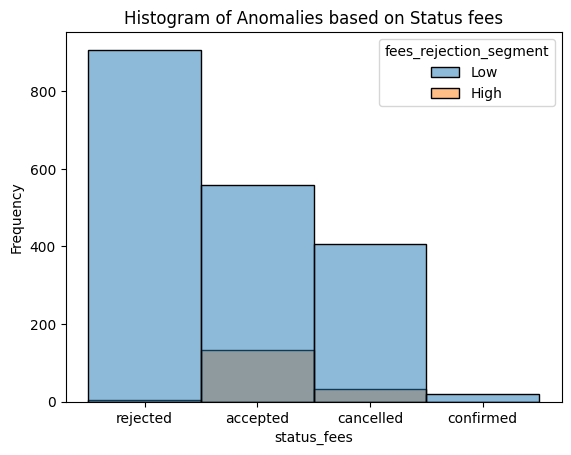

In [170]:
import seaborn as sns
sns.histplot(anomalies , x='status_fees', bins =10 , hue='fees_rejection_segment')
plt.title('Histogram of Anomalies based on Status fees')
plt.ylabel('Frequency')
plt.show()

In [171]:
# 1. Calcular el monto adicional basado en el porcentaje
corr_df['calculated_total'] = (corr_df['amount'] * corr_df['total_amount']) / 100

# 2. Calcular el total a pagar
corr_df['total_to_pay'] = corr_df['amount'] + corr_df['calculated_total']

# 3. Verificar los resultados
print(corr_df[['amount', 'total_amount', 'calculated_total', 'total_to_pay']].head(10))


   amount  total_amount  calculated_total  total_to_pay
0   100.0           5.0               5.0         105.0
1   100.0           5.0               5.0         105.0
2   100.0           5.0               5.0         105.0
3   100.0           5.0               5.0         105.0
4    50.0           5.0               2.5          52.5
5   100.0           5.0               5.0         105.0
6    50.0           5.0               2.5          52.5
7   100.0           5.0               5.0         105.0
8   100.0           5.0               5.0         105.0
9   100.0           5.0               5.0         105.0


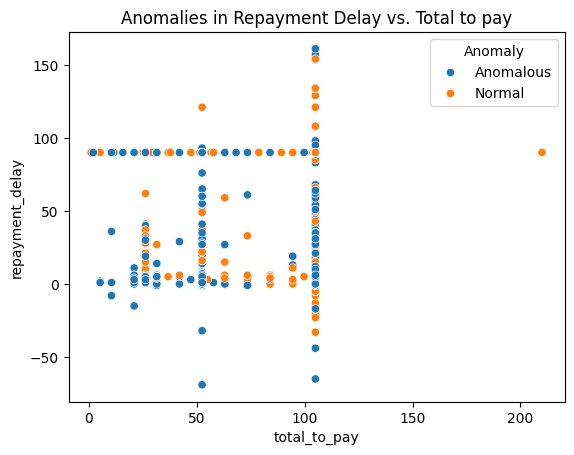

In [172]:
sns.scatterplot(data=corr_df, x="total_to_pay", y="repayment_delay", hue="Anomaly")
plt.title("Anomalies in Repayment Delay vs. Total to pay")
plt.show()

In [173]:
max_repayment_delay= corr_df['repayment_delay'].max()

In [174]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
corr_df["LOF_Anomaly_Score"] = lof.fit_predict(X)

print(corr_df["LOF_Anomaly_Score"].value_counts())  # Compare with Isolation Forest results

LOF_Anomaly_Score
 1    19462
-1     1595
Name: count, dtype: int64


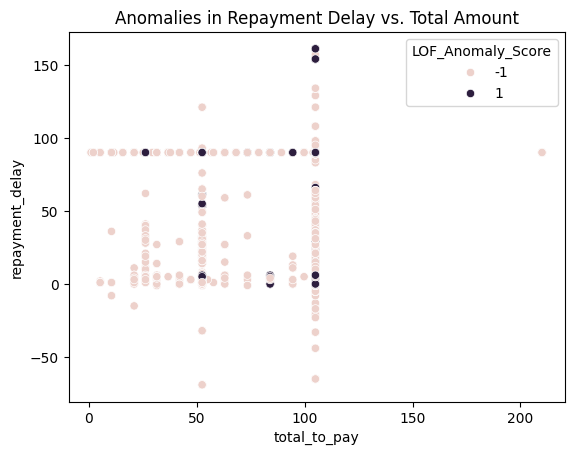

In [175]:
sns.scatterplot(data=corr_df, x="total_to_pay", y="repayment_delay", hue="LOF_Anomaly_Score")
plt.title("Anomalies in Repayment Delay vs. Total Amount")
plt.show()

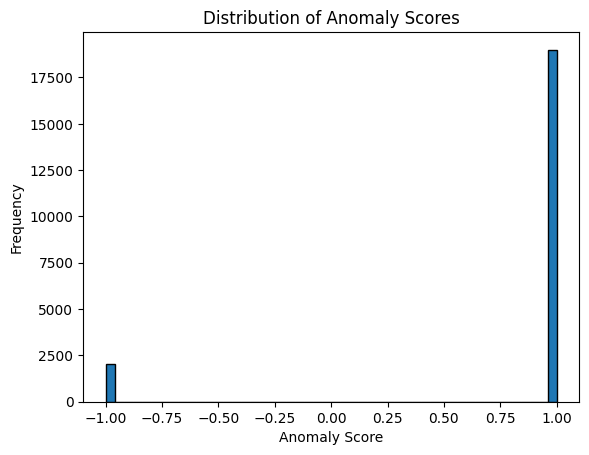

In [176]:
import matplotlib.pyplot as plt

plt.hist(corr_df["Anomaly_Score"], bins=50, edgecolor='black')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

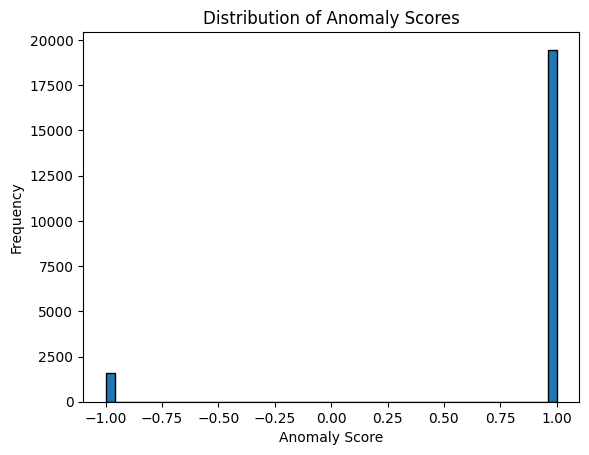

In [177]:
plt.hist(corr_df["LOF_Anomaly_Score"], bins=50, edgecolor='black')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

In [178]:
print(corr_df[["Anomaly_Score", "LOF_Anomaly_Score"]].value_counts())

Anomaly_Score  LOF_Anomaly_Score
 1              1                   18181
-1              1                    1281
 1             -1                     817
-1             -1                     778
Name: count, dtype: int64


In [179]:
# Combine results from both algorithms
corr_df["Combined_Anomaly"] = (
    (corr_df["Anomaly_Score"] == -1) | (corr_df["LOF_Anomaly_Score"] == -1)
)

# Count combined anomalies
print(corr_df["Combined_Anomaly"].value_counts())

Combined_Anomaly
False    18181
True      2876
Name: count, dtype: int64


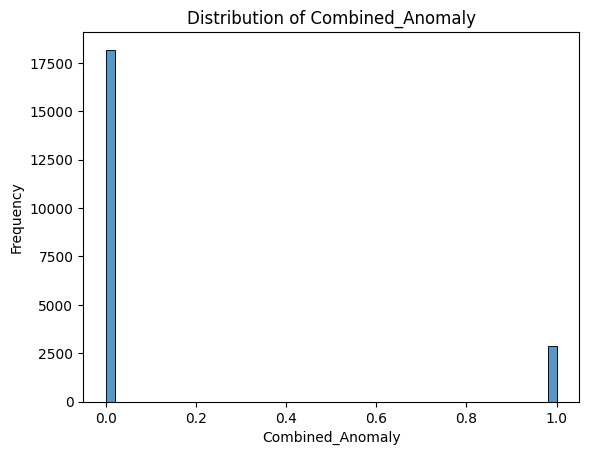

In [180]:
sns.histplot(corr_df["Combined_Anomaly"], bins=50, edgecolor='black')
plt.xlabel("Combined_Anomaly")
plt.ylabel("Frequency")
plt.title("Distribution of Combined_Anomaly")
plt.show()

In [181]:
print(corr_df["Combined_Anomaly"].value_counts(normalize=True) * 100)

Combined_Anomaly
False    86.341834
True     13.658166
Name: proportion, dtype: float64


In [182]:
anomalies = corr_df[corr_df["Combined_Anomaly"] == True]
anomalies[['user_id' ,'cash_request_id', 'total_to_pay', 'repayment_delay', 'Repayment_Status' , 'fees_rejection_segment']].head(50)

user_id  cash_request_id  total_to_pay  repayment_delay  \
0     35661.0          14941.0        105.00              5.0   
27    12710.0          10287.0        105.00             90.0   
42    37011.0          25769.0         26.25             90.0   
43    64641.0          19981.0        105.00             90.0   
44     2142.0          12952.0         31.50             90.0   
47    33061.0           9338.0         63.00             90.0   
55    97197.0          26575.0         10.50             36.0   
70    29796.0          22977.0         52.50             15.0   
79    96086.0          26494.0         63.00              4.0   
87    32586.0          16534.0         36.75             90.0   
94    37157.0          14814.0         52.50             28.0   
106       NaN          14924.0         52.50             31.0   
110   22660.0           7222.0         52.50             90.0   
115   35676.0          14093.0         21.00             90.0   
143   14384.0           3229.0        105.00            157.0   
168   31511.0           7855.0        105.00             90.0   
186   14725.0          14588.0        105.00             22.0   
193   54178.0          18606.0         52.50              3.0   
206   21476.0          14754.0         52.50             31.0   
207   14725.0          14588.0        105.00             22.0   
229   40769.0          18874.0         52.50              2.0   
236   85495.0          23494.0         52.50              6.0   
268   46519.0          19074.0         52.50             36.0   
281   27319.0          24505.0         26.25             90.0   
297    4644.0           3068.0        105.00            -44.0   
298   45677.0          20244.0         52.50             90.0   
302   98263.0          26125.0        105.00              6.0   
330  101813.0          26781.0        105.00              5.0   
333   45677.0          20244.0         52.50             90.0   
334   11294.0          14649.0         52.50             90.0   
336   21685.0          10173.0         52.50             90.0   
345   93661.0          25141.0         26.25             90.0   
356    4830.0           4367.0        105.00             90.0   
359   36320.0          15633.0        105.00             31.0   
365   89318.0          26582.0         26.25             90.0   
373   90621.0          25388.0         21.00              3.0   
387   34471.0          18803.0         52.50             37.0   
392   22764.0          15730.0        105.00             28.0   
394   33204.0          13797.0         52.50             28.0   
407   46065.0          17383.0         63.00             90.0   
426   34471.0          18803.0         52.50             37.0   
430   40497.0          24509.0         52.50             90.0   
441  102350.0          26874.0        105.00              7.0   
468   34872.0          16577.0         73.50             90.0   
485    8412.0          14650.0        105.00             28.0   
487   15019.0          14690.0         73.50              6.0   
490   83184.0          22704.0         42.00              6.0   
492   25105.0           5807.0         42.00             90.0   
504   87775.0          25785.0         26.25             90.0   
560   12099.0           2466.0         52.50             90.0   

    Repayment_Status fees_rejection_segment  
0         Late Payer                    Low  
27         Defaulter                    Low  
42         Defaulter                    Low  
43         Defaulter                    Low  
44         Defaulter                    Low  
47        Late Payer                    Low  
55        Late Payer                    Low  
70        Late Payer                    Low  
79        Late Payer                    Low  
87         Defaulter                    Low  
94        Late Payer                    Low  
106       Late Payer                    Low  
110        Defaulter                    Low  
115        Defaulter                    Low  


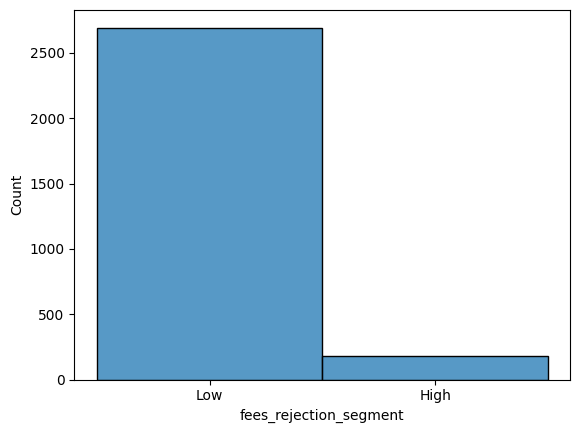

In [183]:
sns.histplot(anomalies , x='fees_rejection_segment')
plt.show()

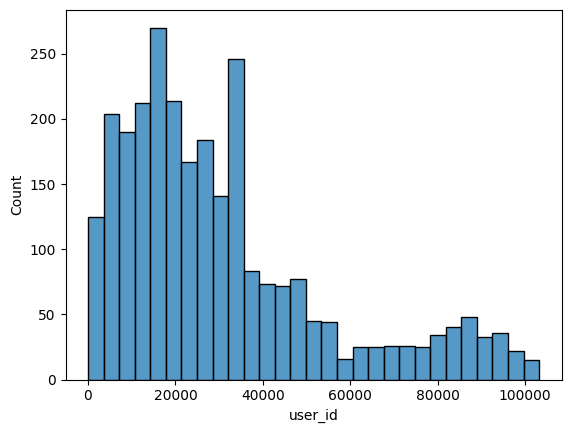

In [184]:
sns.histplot(anomalies , x='user_id')
plt.show()

<Axes: xlabel='Repayment_Status', ylabel='Count'>

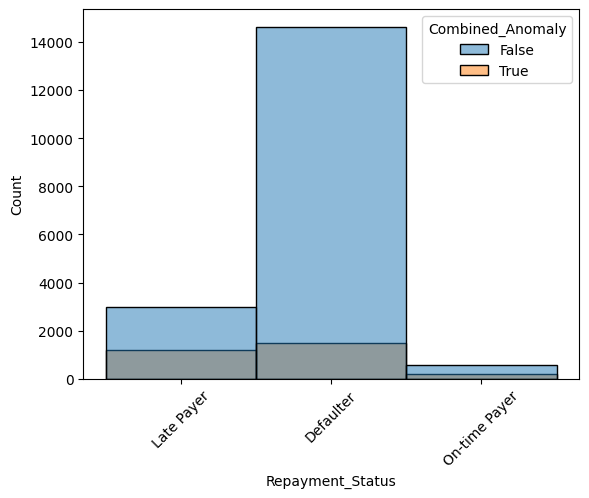

In [185]:
plt.xticks(rotation=45)
sns.histplot(data=corr_df , x='Repayment_Status' , hue='Combined_Anomaly')

        user_id  cash_request_id  total_amount  Combined_Anomaly
0       35661.0          14941.0           5.0              True
27      12710.0          10287.0           5.0              True
42      37011.0          25769.0           5.0              True
43      64641.0          19981.0           5.0              True
44       2142.0          12952.0           5.0              True
...         ...              ...           ...               ...
21049   48059.0          17642.0           5.0              True
21052   64923.0          20262.0           5.0              True
21053  100564.0          26764.0           5.0              True
21054   70754.0          25331.0           5.0              True
21055   72437.0          23628.0           5.0              True

[2876 rows x 4 columns]


<Axes: xlabel='total_amount', ylabel='Count'>

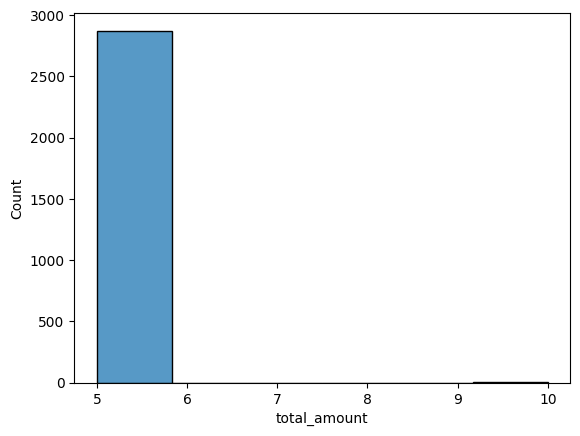

In [186]:
anomal_data = corr_df[corr_df['Combined_Anomaly']== True]
print(anomal_data[['user_id','cash_request_id','total_amount', 'Combined_Anomaly']])
sns.histplot(data=anomal_data, x='total_amount', bins=6)

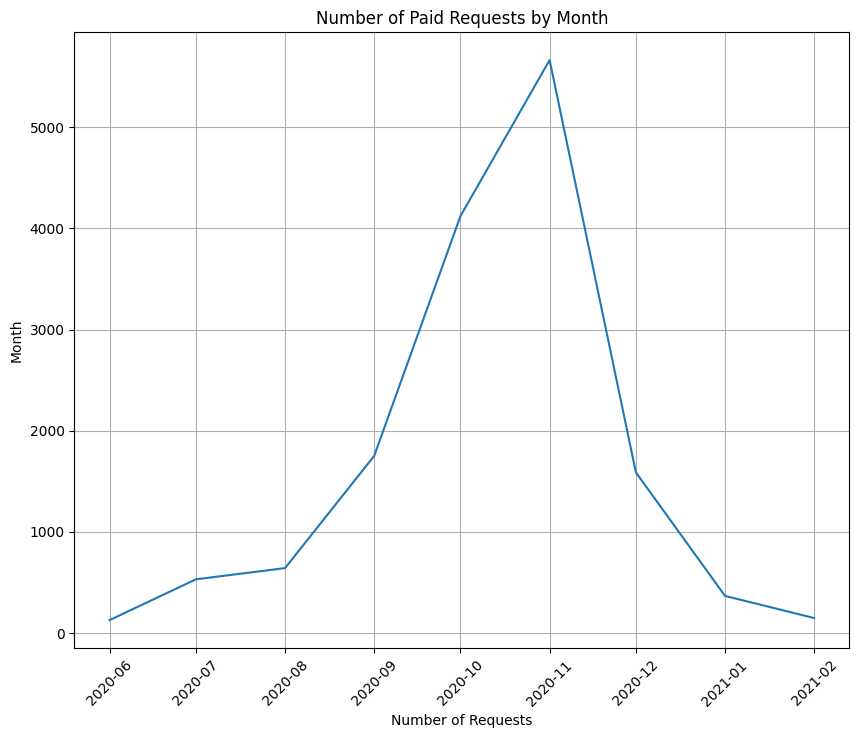

In [187]:
paid_count_per_month = corr_df.groupby('paid_at_Month')['user_id'].count().reset_index()
paid_count_per_month['paid_at_Month'] = paid_count_per_month['paid_at_Month'].dt.to_timestamp()
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
sns.lineplot(data=paid_count_per_month , y='user_id' , x='paid_at_Month' )
plt.title('Number of Paid Requests by Month')
plt.xlabel('Number of Requests')
plt.ylabel('Month')
plt.grid()
plt.show()

In [188]:
# distribution of Anomalies over other features
features = corr_df.describe().columns

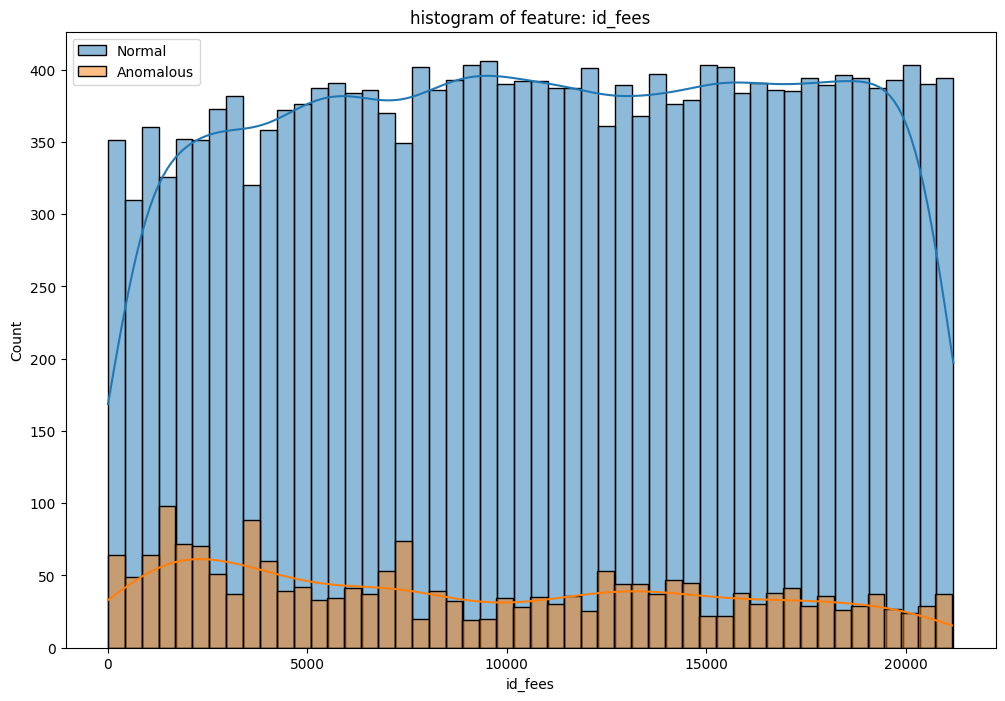

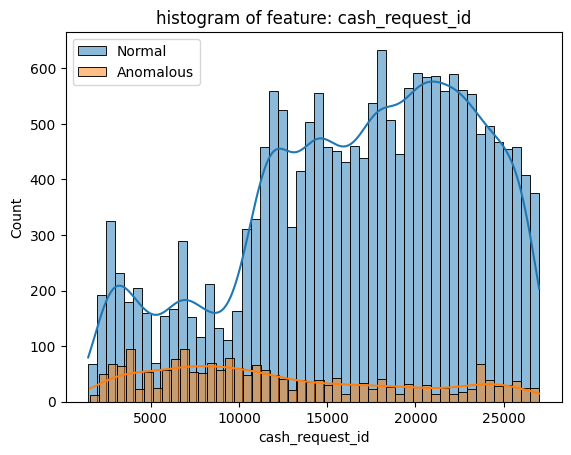

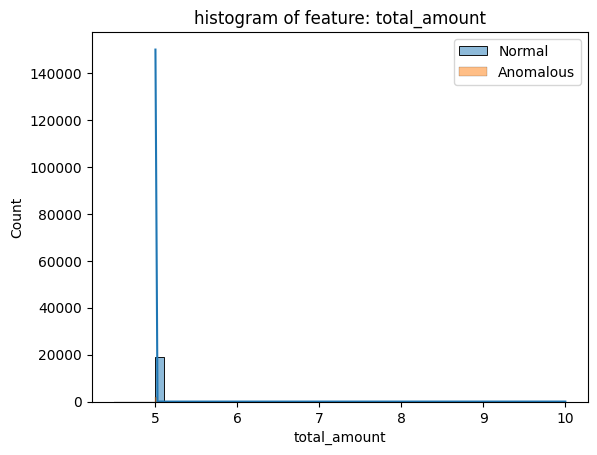

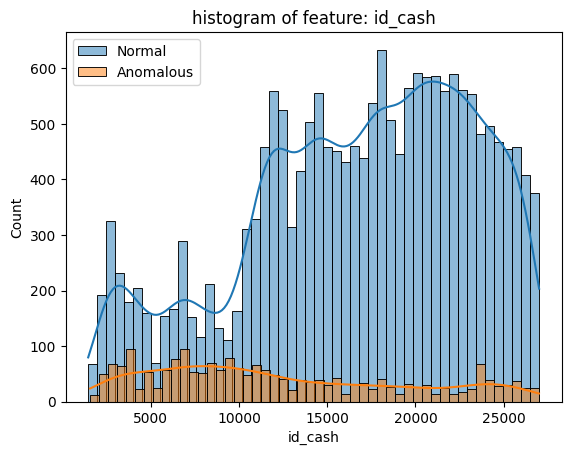

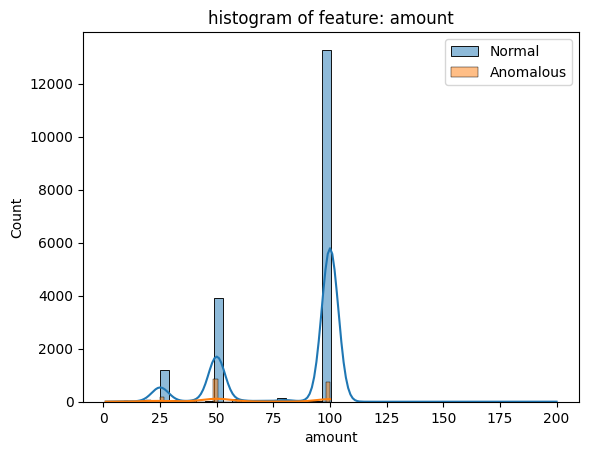

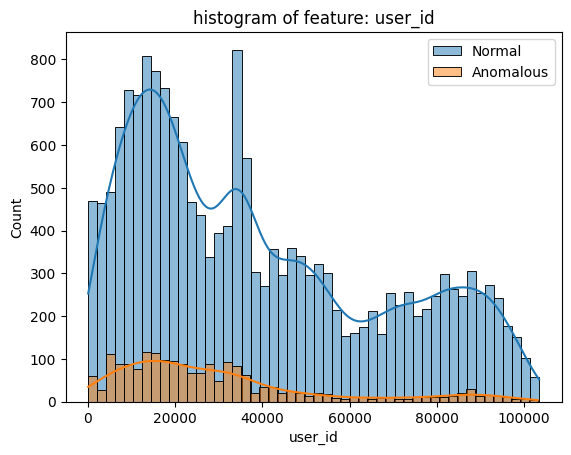

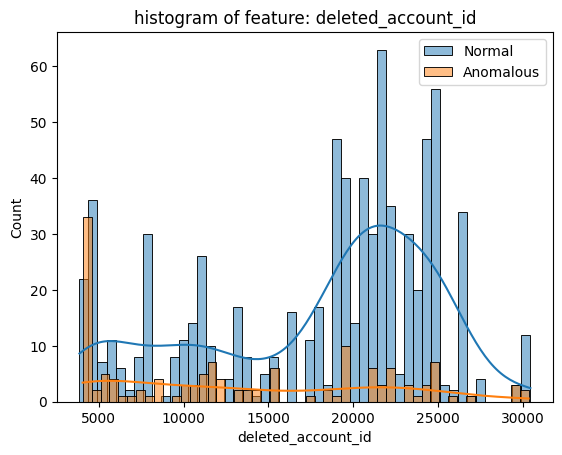

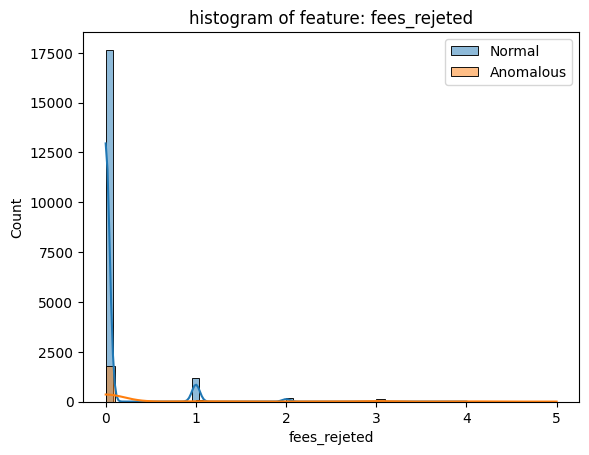

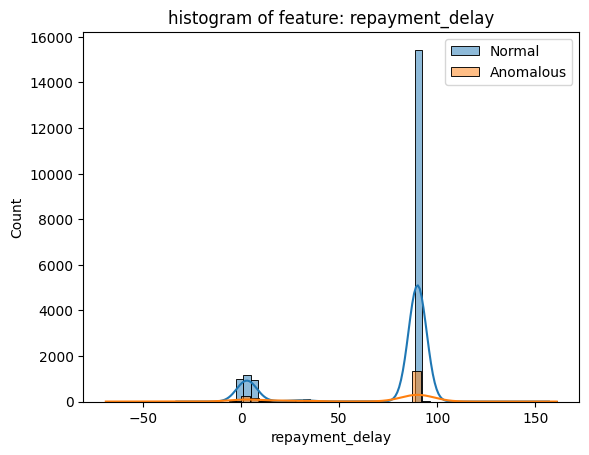

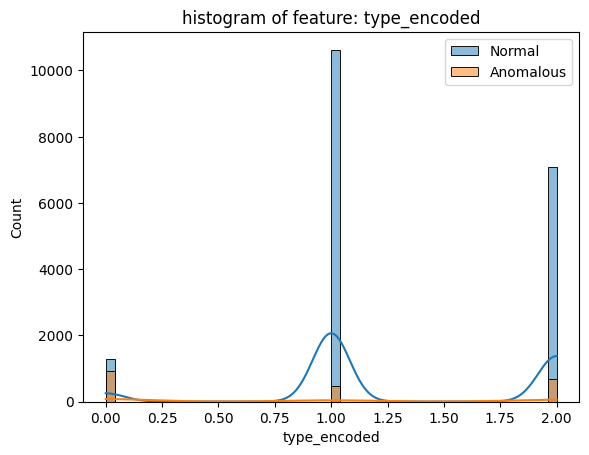

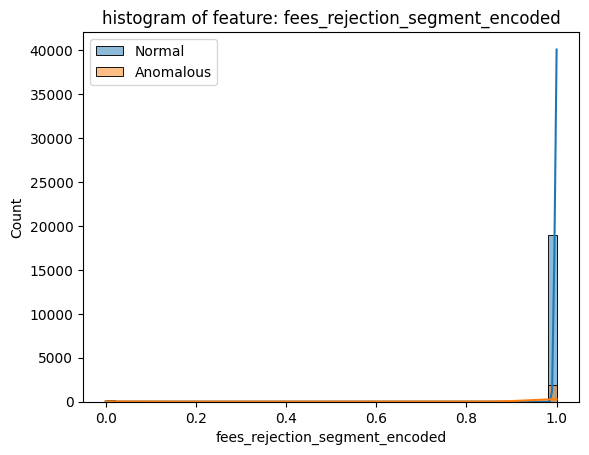

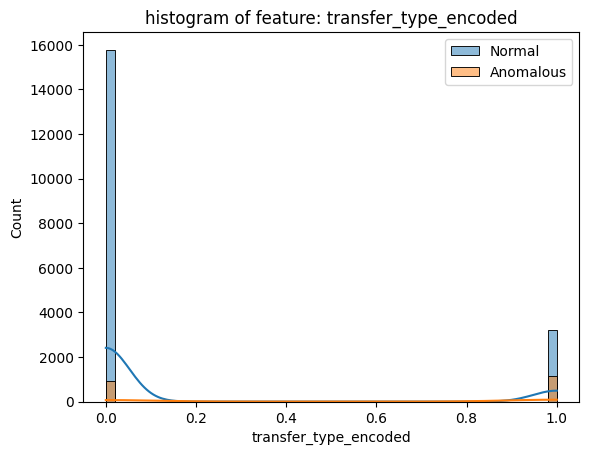

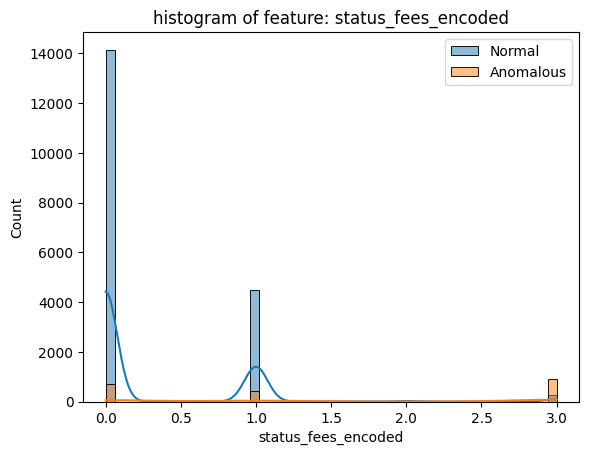

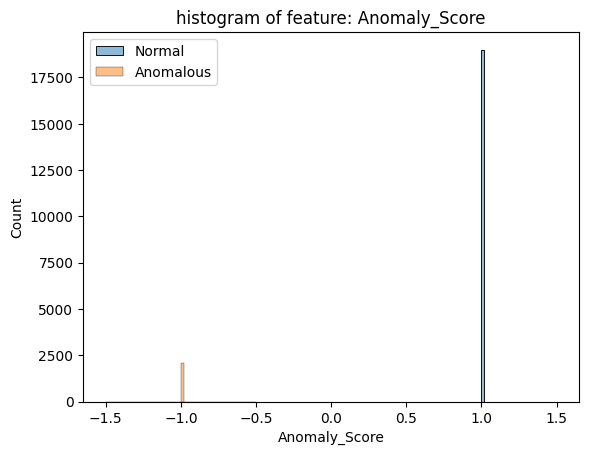

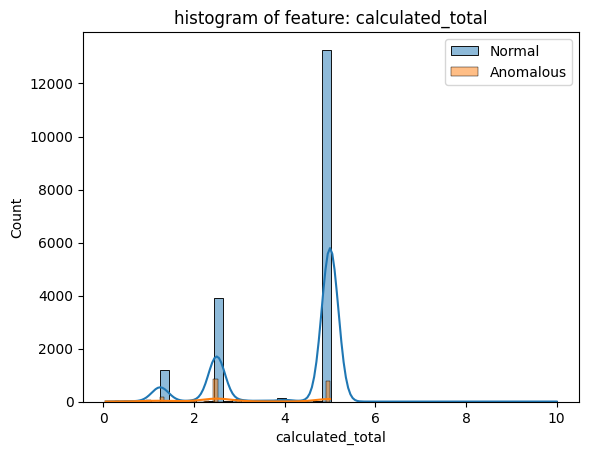

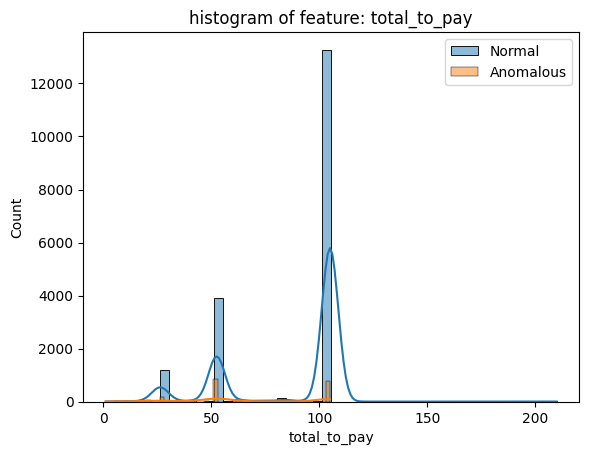

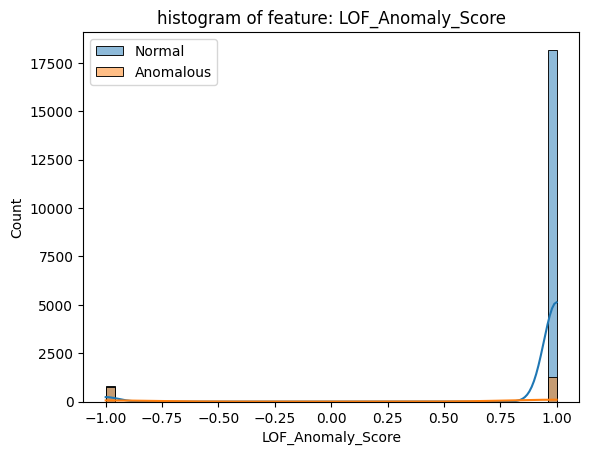

In [189]:
plt.figure(figsize=(12,8))

for feature in features:
    sns.histplot(corr_df[feature][corr_df.Anomaly_Score == 1], bins=50, kde=True, label="Normal")
    sns.histplot(corr_df[feature][corr_df.Anomaly_Score == -1], bins=50, kde=True, label="Anomalous")
    plt.title('histogram of feature: ' + str(feature))
    plt.legend()
    plt.show()

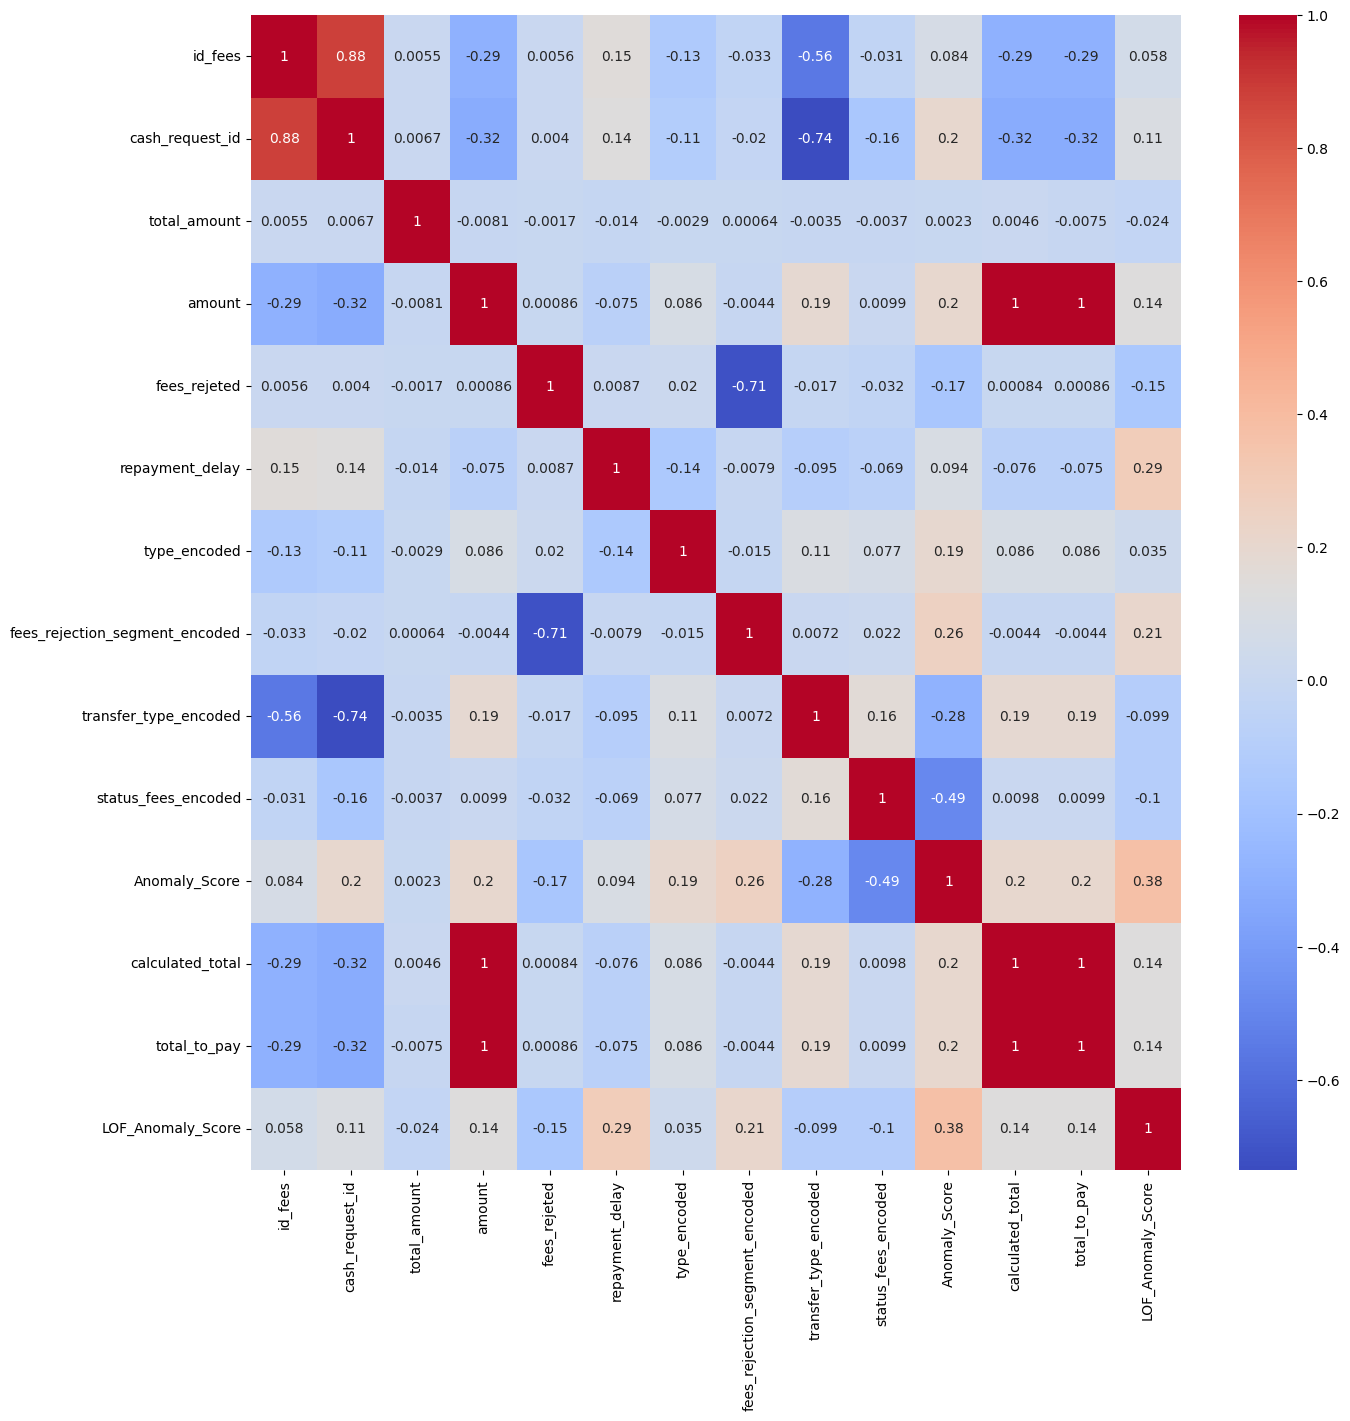

array([False])

In [190]:
corr_df= corr_df.drop(columns=['id_cash', 'deleted_account_id', 'user_id'])
totalS_nan= corr_df.total_amount.isna()
corr_matrix = corr_df[corr_df.describe().columns].corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()
totalS_nan.unique()

In [191]:
corr_df.columns

Index(['id_fees', 'cash_request_id', 'type', 'status_fees', 'category',
       'total_amount', 'reason', 'updated_at_fees', 'from_date', 'to_date',
       'charge_moment', 'amount', 'status_cash', 'created_at_cash',
       'updated_at_cash', 'moderated_at', 'transfer_type', 'recovery_status',
       'fees_rejeted', 'fees_rejection_segment', 'repayment_delay',
       'Repayment_Status', 'reimbursement_date_Month', 'paid_at_Month',
       'created_at_fees_Month', 'cash_request_received_date_Month',
       'money_back_date_Month', 'send_at_Month', 'reco_creation_Month',
       'reco_last_update_Month', 'type_encoded',
       'fees_rejection_segment_encoded', 'transfer_type_encoded',
       'status_fees_encoded', 'Anomaly_Score', 'Anomaly', 'calculated_total',
       'total_to_pay', 'LOF_Anomaly_Score', 'Combined_Anomaly'],
      dtype='object')

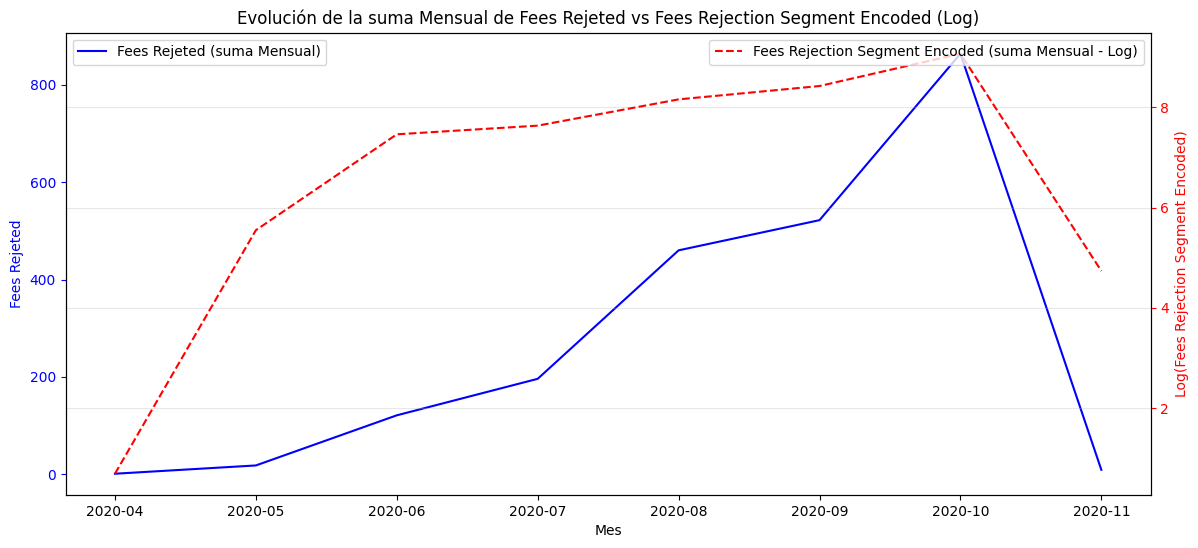

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

required_columns = ['created_at_cash', 'fees_rejeted', 'fees_rejection_segment_encoded']
missing_columns = [col for col in required_columns if col not in corr_df.columns]

if not missing_columns:
  
    corr_df['created_at_cash'] = pd.to_datetime(corr_df['created_at_cash'])


    corr_df['Month'] = corr_df['created_at_cash'].dt.to_period('M')

 
    time_series_data = corr_df.groupby('Month').agg({
        'fees_rejeted': 'sum',
        'fees_rejection_segment_encoded': 'sum'
    }).reset_index()


    time_series_data['Month'] = time_series_data['Month'].astype(str)

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Crear segundo eje Y
    ax2 = ax1.twinx()  

    # Graficar 'fees_rejeted' en escala normal
    ax1.plot(time_series_data['Month'], time_series_data['fees_rejeted'], 
            label='Fees Rejeted (suma Mensual)', color='blue', linestyle='-')

    # Graficar 'fees_rejection_segment_encoded'  con escala logarítmica
    ax2.plot(time_series_data['Month'], np.log1p(time_series_data['fees_rejection_segment_encoded']), 
            label='Fees Rejection Segment Encoded (suma Mensual - Log)', color='red', linestyle='--')

    # Etiquetas de los ejes
    ax1.set_xlabel('Mes')
    ax1.set_ylabel('Fees Rejeted', color='blue')
    ax2.set_ylabel('Log(Fees Rejection Segment Encoded)', color='red')

    # Configuración de colores para distinguir los ejes
    ax1.tick_params(axis='y', colors='blue')
    ax2.tick_params(axis='y', colors='red')

    # Leyendas para cada serie de datos
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Configuración del título y estilos
    plt.title('Evolución de la suma Mensual de Fees Rejeted vs Fees Rejection Segment Encoded (Log)')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)

    # Mostrar el gráfico
    plt.show()


else:
    print(f" Las siguientes columnas faltan en corr_df: {missing_columns}. Verifica los nombres y la carga de datos.")




In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


fees = pd.read_csv('./data/extract - fees - data analyst - .csv')
cash_request = pd.read_csv('./data/extract - cash request - data analyst.csv')


cr = cash_request.copy()
cr = cr[['amount', 'created_at', 'user_id', 'deleted_account_id', 'transfer_type']]

# Convertir 'created_at' a datetime
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr['created_at'] = cr['created_at'].dt.tz_localize(None)

# Rellenar 'user_id' con 'deleted_account_id' donde sea NaN
cr['user_id'] = cr['user_id'].combine_first(cr['deleted_account_id'])
cr.drop(columns=['deleted_account_id'], inplace=True)

# Convertir a periodos diarios en lugar de mensuales
cr['Day'] = cr['created_at'].dt.to_period('D')  # Se usa 'D' para periodos diarios

# Calcular la cohorte diaria (primer día de uso por usuario)
cr['cohort_d'] = cr.groupby('user_id')['Day'].transform('min')

# Agrupar por cohort_d y contar usuarios iniciales
cohort_daily_initial_sizes = cr.groupby('cohort_d').agg(
    Number_of_initial_customers=('user_id', 'nunique')
).reset_index()

# Agrupar por cohort_d y Day para contar usuarios activos
cohort_daily_sizes = cr.groupby(['cohort_d', 'Day']).agg(
    Number_of_customers=('user_id', 'nunique')
).reset_index()

# Agrupar por cohort_d y Day para contar solicitudes
cohort_cash_daily = cr.groupby(['cohort_d', 'Day']).agg(
    Num_requests=('user_id', 'count')
).reset_index()

# Convertir 'Day' a datetime para cálculos correctos
cohort_daily_sizes['Day'] = cohort_daily_sizes['Day'].astype(str)
cohort_daily_sizes['Day'] = pd.to_datetime(cohort_daily_sizes['Day'])

# Calcular tasa de retención diaria
customers_daily_retention = cohort_daily_sizes.pivot(index='cohort_d', columns='Day', values='Number_of_customers')

# Dividir cada día por el número inicial de clientes en cada cohorte
customers_daily_retention = customers_daily_retention.div(
    cohort_daily_initial_sizes.set_index('cohort_d')['Number_of_initial_customers'], axis=0
)

# Convertir la tabla a formato largo para análisis de series temporales
df_churn = customers_daily_retention.reset_index().melt(id_vars=['cohort_d'], var_name='Day', value_name='Retention_Rate')

# Asegurar que 'Day' es datetime
df_churn['Day'] = pd.to_datetime(df_churn['Day'])

# Calcular la diferencia en días correctamente (desde cohort_d hasta Day)
df_churn['cohort_d'] = df_churn['cohort_d'].astype(str)  # Convertir a string para evitar errores
df_churn['cohort_d'] = pd.to_datetime(df_churn['cohort_d'])  # Convertir a datetime
df_churn['Day_Num'] = (df_churn['Day'] - df_churn['cohort_d']).dt.days

# Verificar los datos corregidos
df_churn

cohort_d        Day  Retention_Rate  Day_Num
0      2019-11-19 2019-11-19             1.0        0
1      2019-12-09 2019-11-19             NaN      -20
2      2019-12-10 2019-11-19             NaN      -21
3      2019-12-11 2019-11-19             NaN      -22
4      2019-12-12 2019-11-19             NaN      -23
...           ...        ...             ...      ...
104275 2020-10-28 2020-11-01             NaN        4
104276 2020-10-29 2020-11-01             NaN        3
104277 2020-10-30 2020-11-01             NaN        2
104278 2020-10-31 2020-11-01             NaN        1
104279 2020-11-01 2020-11-01             1.0        0

[104280 rows x 4 columns]

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import IsolationForest

warnings.filterwarnings('ignore')

fees = pd.read_csv('./data/extract - fees - data analyst - .csv')
cash_request = pd.read_csv('./data/extract - cash request - data analyst.csv')

cr = cash_request.copy()
cr = cr[['amount', 'created_at', 'user_id', 'deleted_account_id', 'transfer_type']]
##crosstab
anomalies = corr_df[corr_df["Combined_Anomaly"] == True]
anomalies[['user_id' ,'cash_request_id', 'total_to_pay', 'repayment_delay', 'Repayment_Status' , 'fees_rejection_segment']]
merged_data = anomalies[['user_id' ,'cash_request_id', 'total_to_pay', 'repayment_delay', 'Repayment_Status' , 'fees_rejection_segment']].merge(cr, on='user_id', how='outer') 

merged_data


KeyError: "['user_id'] not in index"

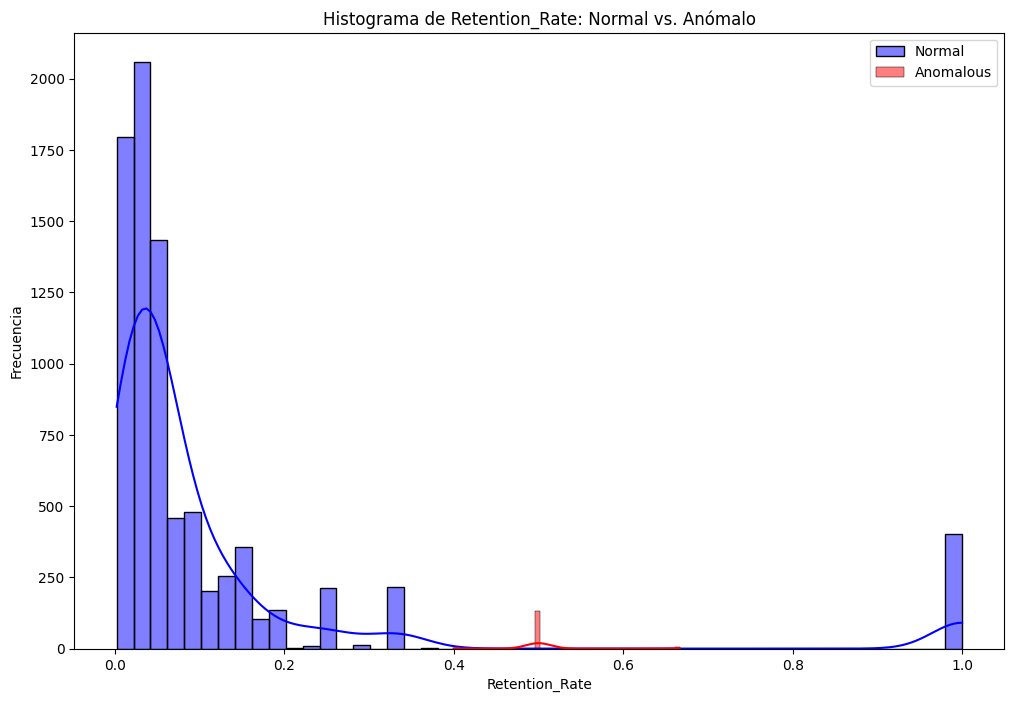

In [227]:


merged_data['created_at'] = pd.to_datetime(merged_data['created_at'])
merged_data['created_at'] = merged_data['created_at'].dt.tz_localize(None)

merged_data['user_id'] = merged_data['user_id'].combine_first(cr['deleted_account_id'])
cr.drop(columns=['deleted_account_id'], inplace=True)

merged_data['Day'] = merged_data['created_at'].dt.to_period('D')

merged_data['cohort_d'] = merged_data.groupby('user_id')['Day'].transform('min')

cohort_daily_initial_sizes = merged_data.groupby('cohort_d').agg(
    Number_of_initial_customers=('user_id', 'nunique')
).reset_index()

cohort_daily_sizes = merged_data.groupby(['cohort_d', 'Day']).agg(
    Number_of_customers=('user_id', 'nunique')
).reset_index()

cohort_daily_sizes['Day'] = cohort_daily_sizes['Day'].astype(str)
cohort_daily_sizes['Day'] = pd.to_datetime(cohort_daily_sizes['Day'])

customers_daily_retention = cohort_daily_sizes.pivot(
    index='cohort_d', 
    columns='Day', 
    values='Number_of_customers'
)

customers_daily_retention = customers_daily_retention.div(
    cohort_daily_initial_sizes.set_index('cohort_d')['Number_of_initial_customers'], 
    axis=0
)

df_churn = customers_daily_retention.reset_index().melt(
    id_vars=['cohort_d'], 
    var_name='Day', 
    value_name='Retention_Rate'
)

df_churn['Day'] = pd.to_datetime(df_churn['Day'])
df_churn['cohort_d'] = df_churn['cohort_d'].astype(str)  
df_churn['cohort_d'] = pd.to_datetime(df_churn['cohort_d'])
df_churn['Day_Num'] = (df_churn['Day'] - df_churn['cohort_d']).dt.days

features = ['Retention_Rate']


df_for_model = df_churn.dropna(subset=features).copy()

# c) Entrenamos un IsolationForest (puedes ajustar hyperparámetros como quieras)
iso_forest = IsolationForest(
    n_estimators=100, 
    contamination=0.05,  # ~5% de outliers esperados
    random_state=42
)
iso_forest.fit(df_for_model[features])


predictions = iso_forest.predict(df_for_model[features])
df_for_model['Anomaly_Score'] = predictions


for feature in features:
    plt.figure(figsize=(12, 8))
    
    # Filtro de valores normales vs. anómalos
    normal_values = df_for_model[df_for_model['Anomaly_Score'] == 1][feature]
    anomalous_values = df_for_model[df_for_model['Anomaly_Score'] == -1][feature]

    sns.histplot(normal_values, bins=50, kde=True, color='blue', label='Normal')
    sns.histplot(anomalous_values, bins=50, kde=True, color='red', label='Anomalous')
    
    plt.title(f'Histograma de {feature}: Normal vs. Anómalo')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()


In [228]:
merged_data


user_id  cash_request_id  total_to_pay  repayment_delay  \
0          34.0              NaN           NaN              NaN   
1          35.0              NaN           NaN              NaN   
2          35.0              NaN           NaN              NaN   
3          35.0              NaN           NaN              NaN   
4          35.0              NaN           NaN              NaN   
...         ...              ...           ...              ...   
358256  29610.0          14499.0          52.5             90.0   
358257  30404.0          14499.0          52.5             90.0   
358258  29911.0          14499.0          52.5             90.0   
358259  29803.0          14499.0          52.5             90.0   
358260  30367.0          14499.0          52.5             90.0   

       Repayment_Status fees_rejection_segment  amount  \
0                   NaN                    NaN   100.0   
1                   NaN                    NaN   100.0   
2                   NaN                    NaN    90.0   
3                   NaN                    NaN    90.0   
4                   NaN                    NaN    90.0   
...                 ...                    ...     ...   
358256        Defaulter                    Low    25.0   
358257        Defaulter                    Low   100.0   
358258        Defaulter                    Low   100.0   
358259        Defaulter                    Low    25.0   
358260        Defaulter                    Low    50.0   

                       created_at transfer_type         Day    cohort_d  \
0      2020-04-20 15:50:21.187257       regular  2020-04-20  2020-04-20   
1      2019-12-13 20:27:38.106778       regular  2019-12-13  2019-12-13   
2      2020-02-28 10:51:11.440880       regular  2020-02-28  2019-12-13   
3      2019-12-28 04:00:22.349592       regular  2019-12-28  2019-12-13   
4      2020-01-27 19:50:46.387431       regular  2020-01-27  2019-12-13   
...                           ...           ...         ...         ...   
358256 2020-10-24 10:22:05.934286       instant  2020-10-24  2020-10-24   
358257 2020-10-21 22:00:18.904317       instant  2020-10-21  2020-10-21   
358258 2020-10-21 00:46:36.590700       instant  2020-10-21  2020-10-21   
358259 2020-10-23 22:56:09.027210       instant  2020-10-23  2020-10-23   
358260 2020-10-27 14:41:25.734910       instant  2020-10-27  2020-10-27   

          Month   Cohort  
0       2020-04  2020-04  
1       2019-12  2019-12  
2       2020-02  2019-12  
3       2019-12  2019-12  
4       2020-01  2019-12  
...         ...      ...  
358256  2020-10  2020-10  
358257  2020-10  2020-10  
358258  2020-10  2020-10  
358259  2020-10  2020-10  
358260  2020-10  2020-10  

[358261 rows x 13 columns]

In [213]:
import pandas as pd
from scipy.stats import chi2_contingency


df = pd.read_csv(".\merged_data.csv")

# Identificar columnas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns

# Eliminar filas con NaN en columnas categóricas para análisis
df_categorical = df[categorical_columns].dropna()

# Crear una tabla de contingencia entre dos variables categóricas
contingency_table = pd.crosstab(df_categorical['Repayment_Status'], df_categorical['fees_rejection_segment'])

# Aplicar la prueba de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Mostrar resultados
print(f"Chi-cuadrado: {chi2}")
print(f"P-valor: {p}")

# Interpretación
if p < 0.05:
    print("Existe una relación significativa entre las variables.")
else:
    print("No hay suficiente evidencia para afirmar una relación entre las variables.")



Chi-cuadrado: 4536.960354819412
P-valor: 0.0
Existe una relación significativa entre las variables.


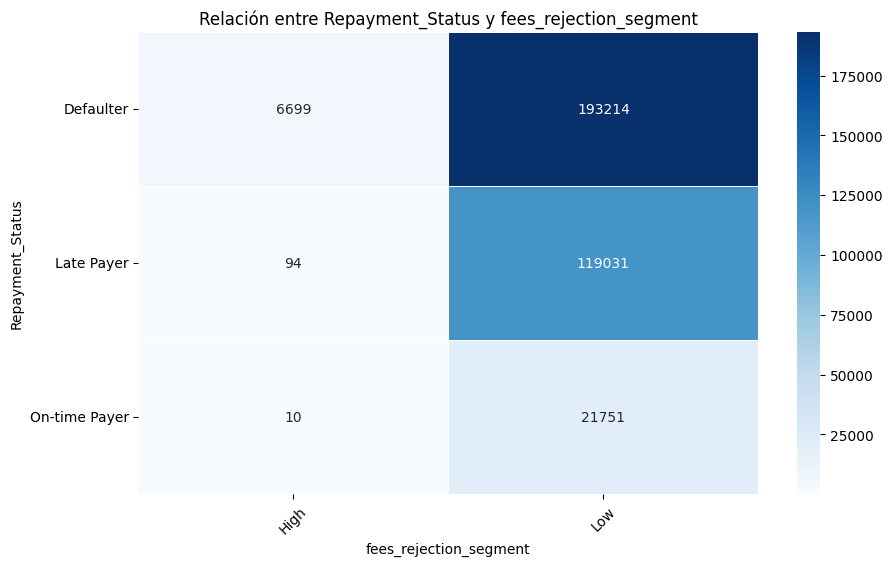

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Identificar columnas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns

# Eliminar filas con NaN en columnas categóricas para análisis
df_categorical = df[categorical_columns].dropna()

# Crear una tabla de contingencia entre 'Repayment_Status' y 'fees_rejection_segment'
contingency_table = pd.crosstab(df_categorical['Repayment_Status'], df_categorical['fees_rejection_segment'])

# Graficar la tabla de contingencia con un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Relación entre Repayment_Status y fees_rejection_segment")
plt.xlabel("fees_rejection_segment")
plt.ylabel("Repayment_Status")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()



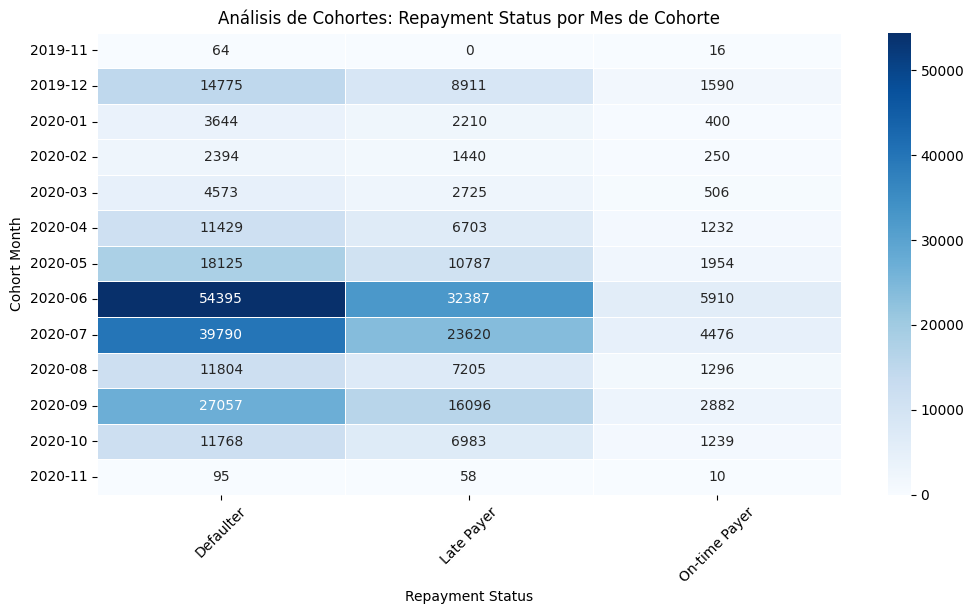

In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Convertir las columnas de fechas a formato datetime
df['cohort_d'] = pd.to_datetime(df['cohort_d'], errors='coerce')
df['Cohort'] = pd.to_datetime(df['Cohort'], errors='coerce')

# Crear una tabla de cohortes para analizar "Repayment_Status" en función del mes de cohorte
cohort_table = pd.crosstab(df['Cohort'].dt.to_period('M'), df['Repayment_Status'])

# Visualizar la evolución de cohortes con un heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cohort_table, cmap="Blues", annot=True, fmt="d", linewidths=0.5)
plt.title("Análisis de Cohortes: Repayment Status por Mes de Cohorte")
plt.xlabel("Repayment Status")
plt.ylabel("Cohort Month")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()


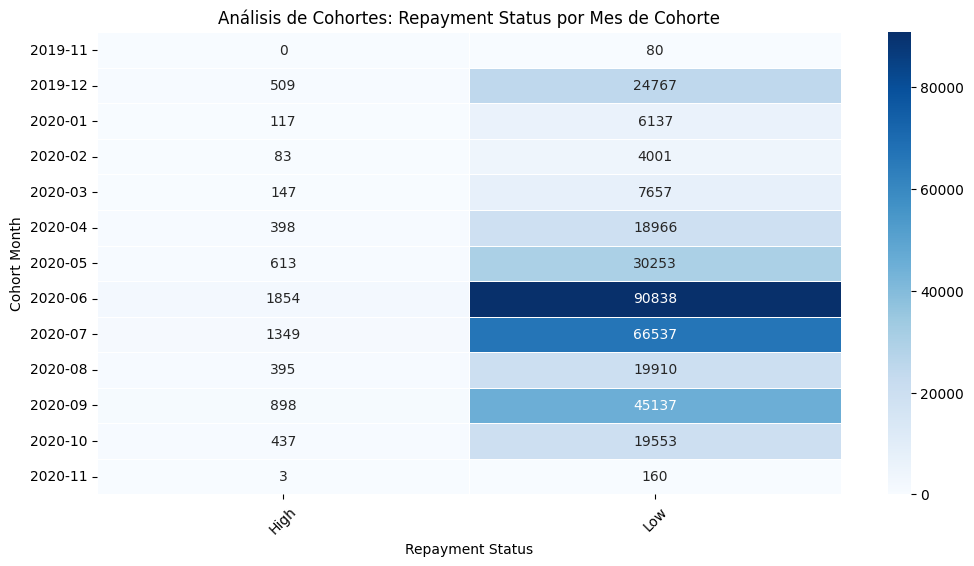

In [223]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Convertir las columnas de fechas a formato datetime
df['cohort_d'] = pd.to_datetime(df['cohort_d'], errors='coerce')
df['Cohort'] = pd.to_datetime(df['Cohort'], errors='coerce')

# Crear una tabla de cohortes para analizar "Repayment_Status" en función del mes de cohorte
cohort_table = pd.crosstab(df['Cohort'].dt.to_period('M'), df['fees_rejection_segment'])

# Visualizar la evolución de cohortes con un heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cohort_table, cmap="Blues", annot=True, fmt="d", linewidths=0.5)
plt.title("Análisis de Cohortes: Repayment Status por Mes de Cohorte")
plt.xlabel("Repayment Status")
plt.ylabel("Cohort Month")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Crear subdatasets en un diccionario, usando 'Repayment_Status' y 'fees_rejection_segment'
subdatasets = {
    f"{status}_{segment}": df_group 
    for (status, segment), df_group in merged_data.groupby(['Repayment_Status', 'fees_rejection_segment'])
}

# Mostrar cuántos subdatasets se crearon
print(f"Se crearon {len(subdatasets)} subdatasets.")

# Ver las claves generadas (nombres de los subdatasets)
print(subdatasets.keys())

Se crearon 6 subdatasets.
dict_keys(['Defaulter_Low', 'Defaulter_High', 'Late Payer_Low', 'Late Payer_High', 'On-time Payer_Low', 'On-time Payer_High'])


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Diccionario para almacenar la retención de cada subdataset
sub_retention = {}

# Procesar cada subdataset
for key, df in subdatasets.items():
    print(f" Procesando subdataset: {key}")

    # Asegurar que 'created_at' es datetime y eliminar zona horaria
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['created_at'] = df['created_at'].dt.tz_localize(None)

    # Verificar si 'deleted_account_id' existe antes de usarlo
    if 'deleted_account_id' in df.columns:
        df['user_id'] = df['user_id'].combine_first(df['deleted_account_id'])
        df.drop(columns=['deleted_account_id'], inplace=True)

    # Convertir a periodos diarios
    df['Day'] = df['created_at'].dt.to_period('D')

    # Calcular la cohorte diaria
    df['cohort_d'] = df.groupby('user_id')['Day'].transform('min')

    # Contar clientes iniciales por cohorte
    cohort_daily_initial_sizes = df.groupby('cohort_d').agg(
        Number_of_initial_customers=('user_id', 'nunique')
    ).reset_index()

    # Contar usuarios activos por cohorte y día
    cohort_daily_sizes = df.groupby(['cohort_d', 'Day']).agg(
        Number_of_customers=('user_id', 'nunique')
    ).reset_index()

    # Convertir 'Day' a datetime
    cohort_daily_sizes['Day'] = cohort_daily_sizes['Day'].astype(str)
    cohort_daily_sizes['Day'] = pd.to_datetime(cohort_daily_sizes['Day'])

    # Calcular tasa de retención diaria
    customers_daily_retention = cohort_daily_sizes.pivot(
        index='cohort_d', columns='Day', values='Number_of_customers'
    )

    # Dividir por número inicial de clientes en cada cohorte
    customers_daily_retention = customers_daily_retention.div(
        cohort_daily_initial_sizes.set_index('cohort_d')['Number_of_initial_customers'], axis=0
    )

    # Convertir tabla a formato largo
    df_churn = customers_daily_retention.reset_index().melt(
        id_vars=['cohort_d'], var_name='Day', value_name='Retention_Rate'
    )

    # Asegurar que 'Day' es datetime
    df_churn['Day'] = pd.to_datetime(df_churn['Day'])

    # Calcular diferencia en días desde cohort_d hasta Day
    df_churn['cohort_d'] = df_churn['cohort_d'].astype(str)  
    df_churn['cohort_d'] = pd.to_datetime(df_churn['cohort_d'])
    df_churn['Day_Num'] = (df_churn['Day'] - df_churn['cohort_d']).dt.days

    # Almacenar el resultado en un diccionario
    sub_retention[key] = df_churn

    print(f"✅ Procesamiento de {key} completado.\n")

# Mostrar los subdatasets procesados
print(" Subdatasets procesados:", sub_retention.keys())





🔹 Procesando subdataset: Defaulter_Low
✅ Procesamiento de Defaulter_Low completado.

🔹 Procesando subdataset: Defaulter_High
✅ Procesamiento de Defaulter_High completado.

🔹 Procesando subdataset: Late Payer_Low
✅ Procesamiento de Late Payer_Low completado.

🔹 Procesando subdataset: Late Payer_High
✅ Procesamiento de Late Payer_High completado.

🔹 Procesando subdataset: On-time Payer_Low
✅ Procesamiento de On-time Payer_Low completado.

🔹 Procesando subdataset: On-time Payer_High
✅ Procesamiento de On-time Payer_High completado.

 Subdatasets procesados: dict_keys(['Defaulter_Low', 'Defaulter_High', 'Late Payer_Low', 'Late Payer_High', 'On-time Payer_Low', 'On-time Payer_High'])


🔹 Generando gráfico de dispersión para: Defaulter_Low


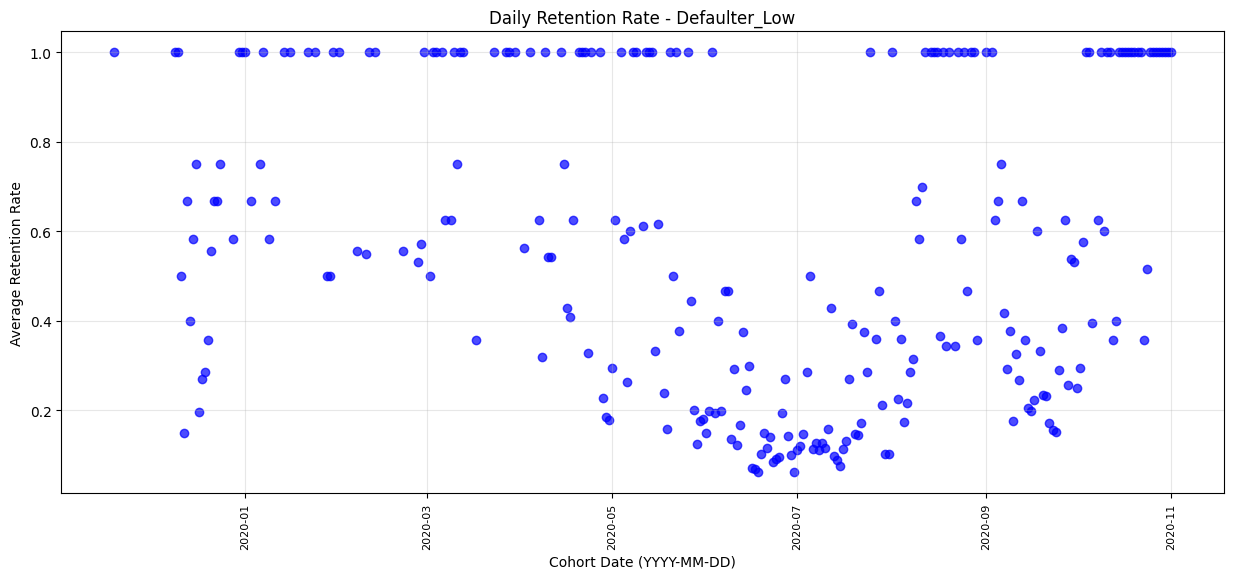

 Gráfico generado para: Defaulter_Low

🔹 Generando gráfico de dispersión para: Defaulter_High


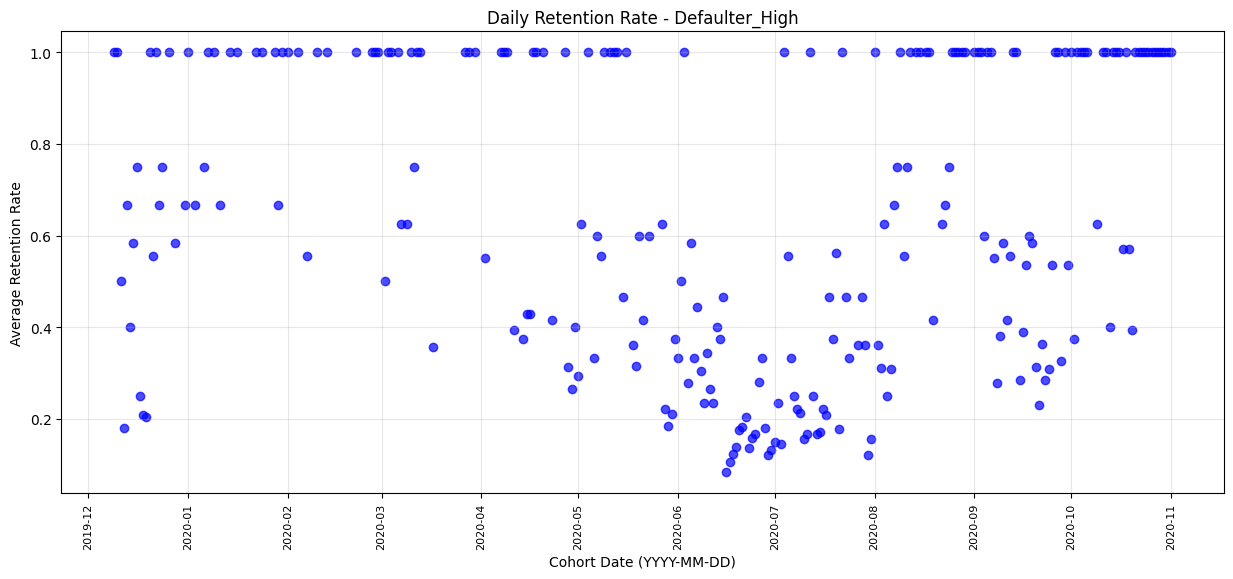

 Gráfico generado para: Defaulter_High

🔹 Generando gráfico de dispersión para: Late Payer_Low


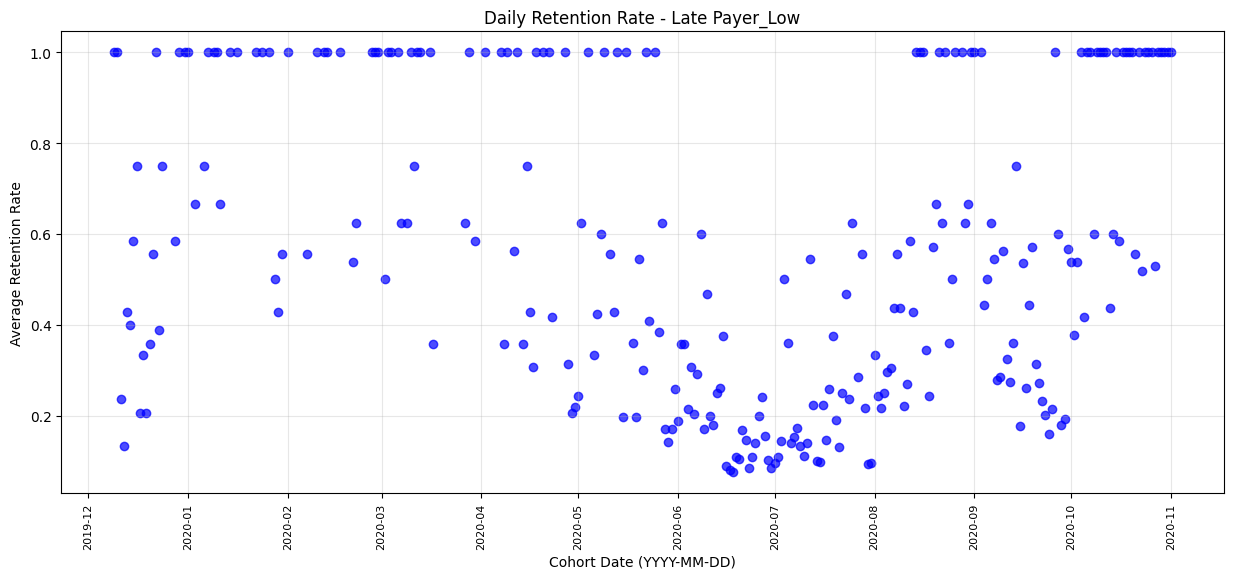

 Gráfico generado para: Late Payer_Low

🔹 Generando gráfico de dispersión para: Late Payer_High


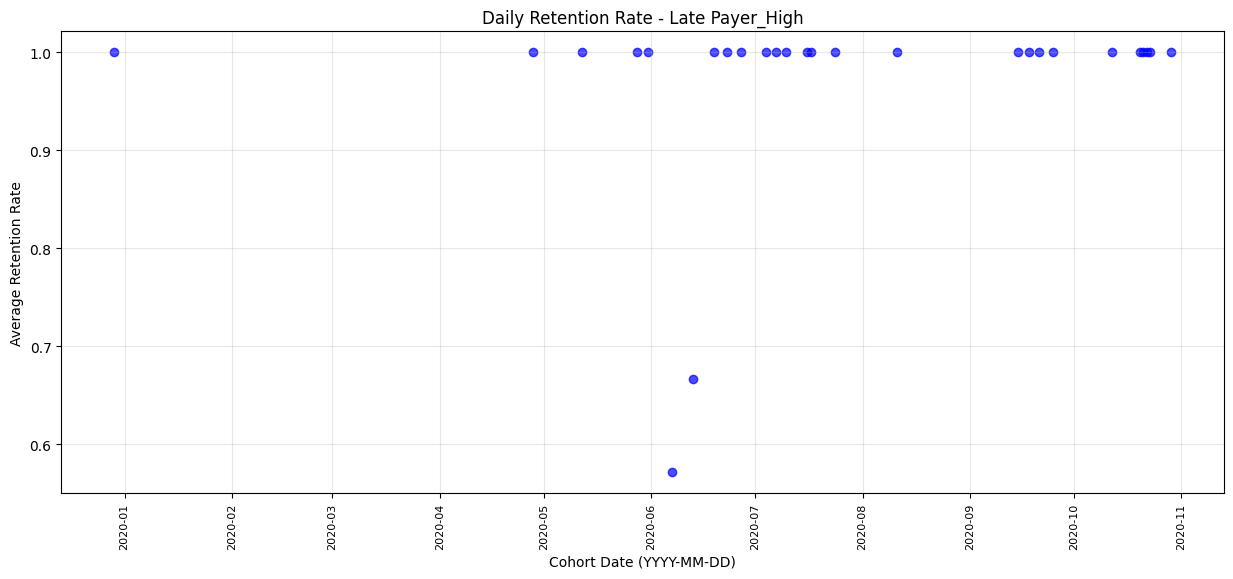

 Gráfico generado para: Late Payer_High

🔹 Generando gráfico de dispersión para: On-time Payer_Low


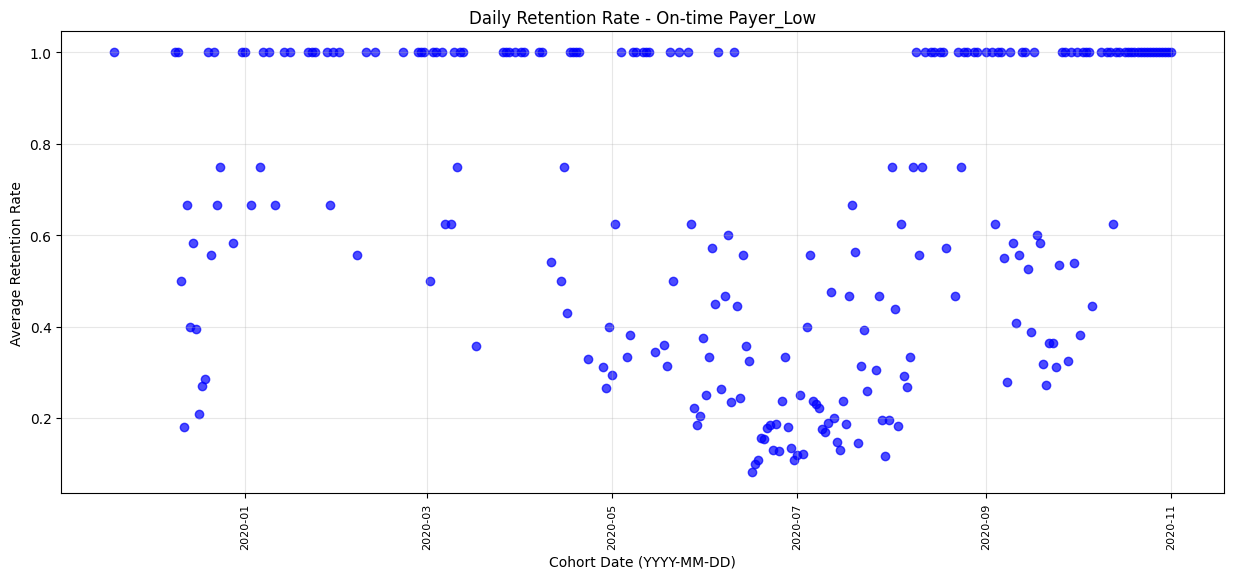

 Gráfico generado para: On-time Payer_Low

🔹 Generando gráfico de dispersión para: On-time Payer_High


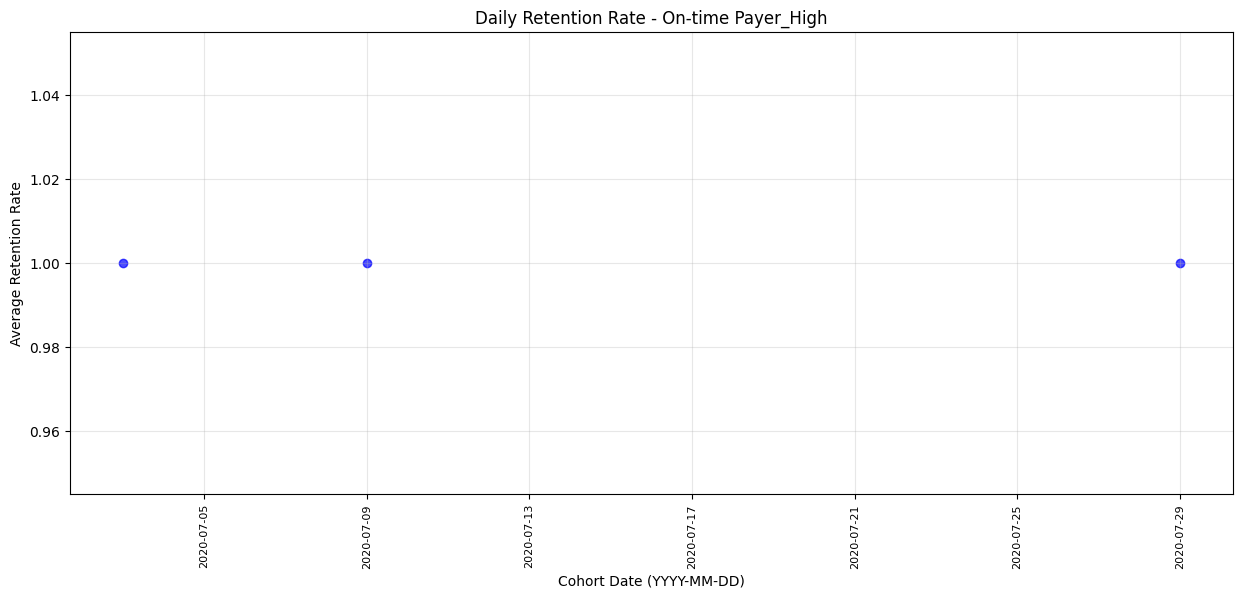

 Gráfico generado para: On-time Payer_High



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


for key, df_churn in sub_retention.items():
    print(f" Generando gráfico de dispersión para: {key}")


    df_churn["cohort_d"] = pd.to_datetime(df_churn["cohort_d"])


    df_daily_mean = df_churn.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
        Mean_Retention_Rate=("Retention_Rate", "mean")
    ).reset_index()


    plt.figure(figsize=(15, 6))
    plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Mean_Retention_Rate"], alpha=0.7, color="blue")

    plt.title(f"Daily Retention Rate - {key}")
    plt.xlabel("Cohort Date (YYYY-MM-DD)")
    plt.ylabel("Average Retention Rate")
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(alpha=0.3)
    plt.show()

    print(f" Gráfico generado para: {key}\n")


🔹 Generando gráfico de dispersión para: Defaulter_Low


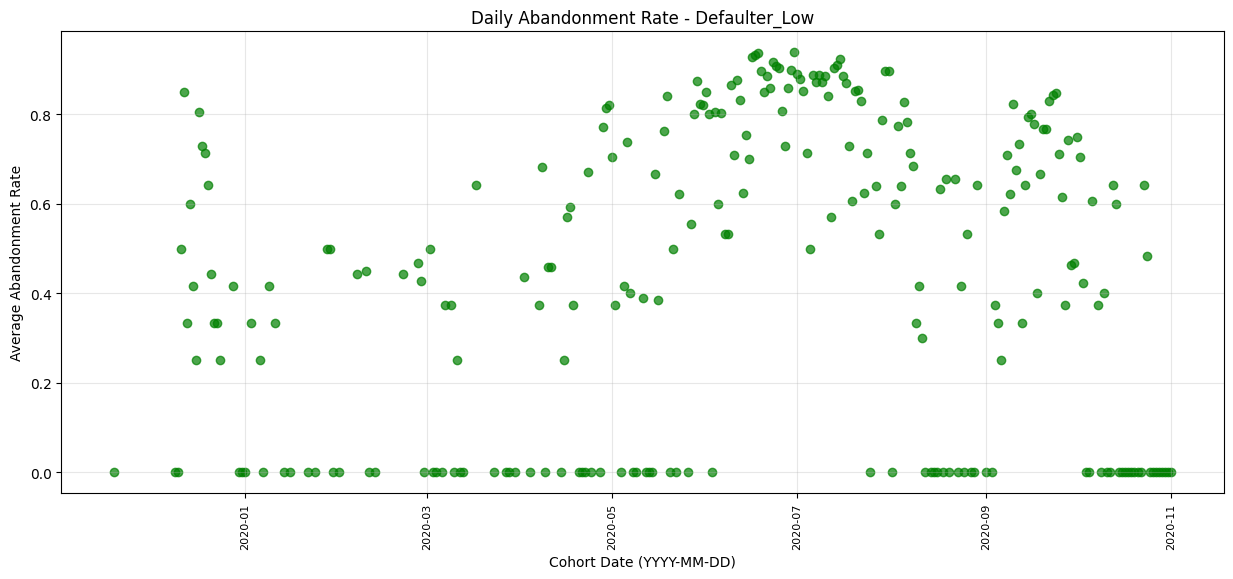

 Gráfico generado para: Defaulter_Low

🔹 Generando gráfico de dispersión para: Defaulter_High


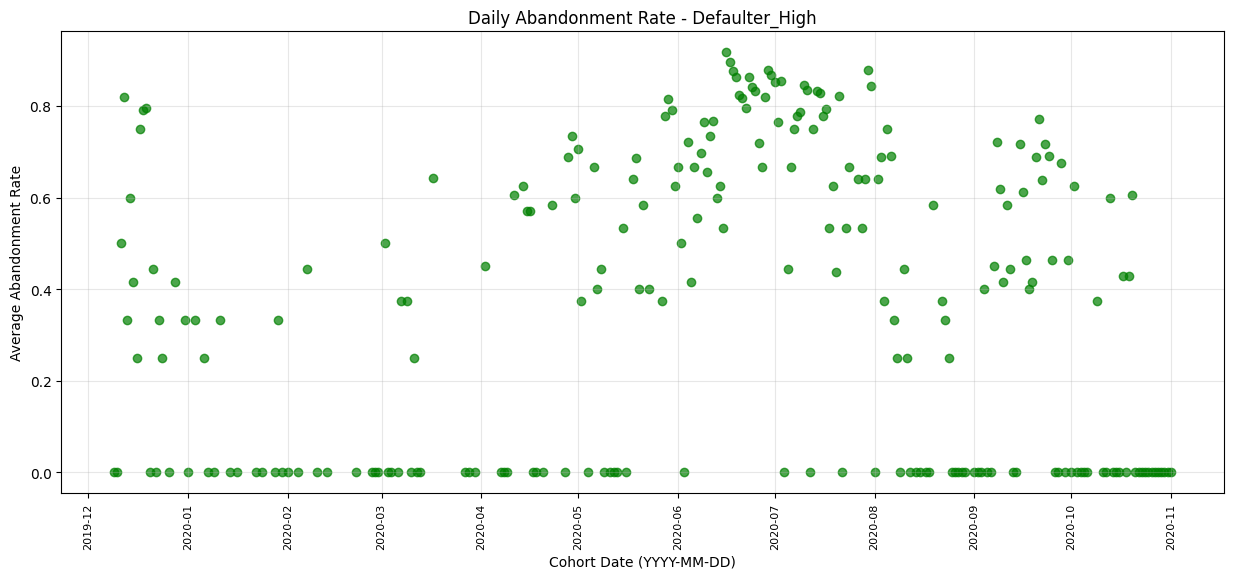

 Gráfico generado para: Defaulter_High

🔹 Generando gráfico de dispersión para: Late Payer_Low


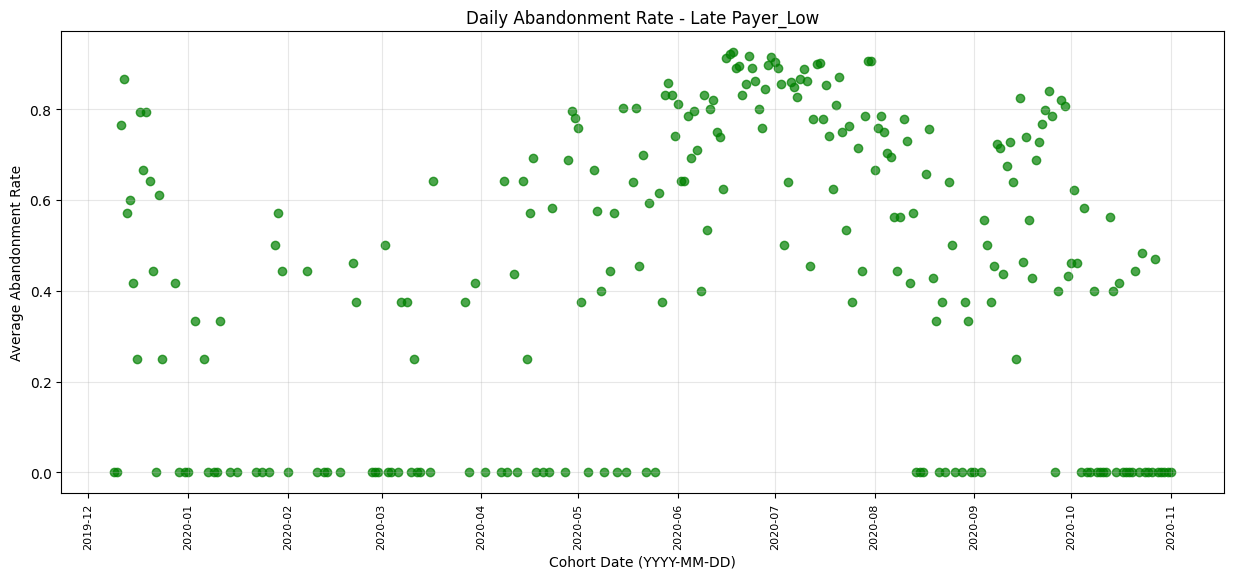

 Gráfico generado para: Late Payer_Low

🔹 Generando gráfico de dispersión para: Late Payer_High


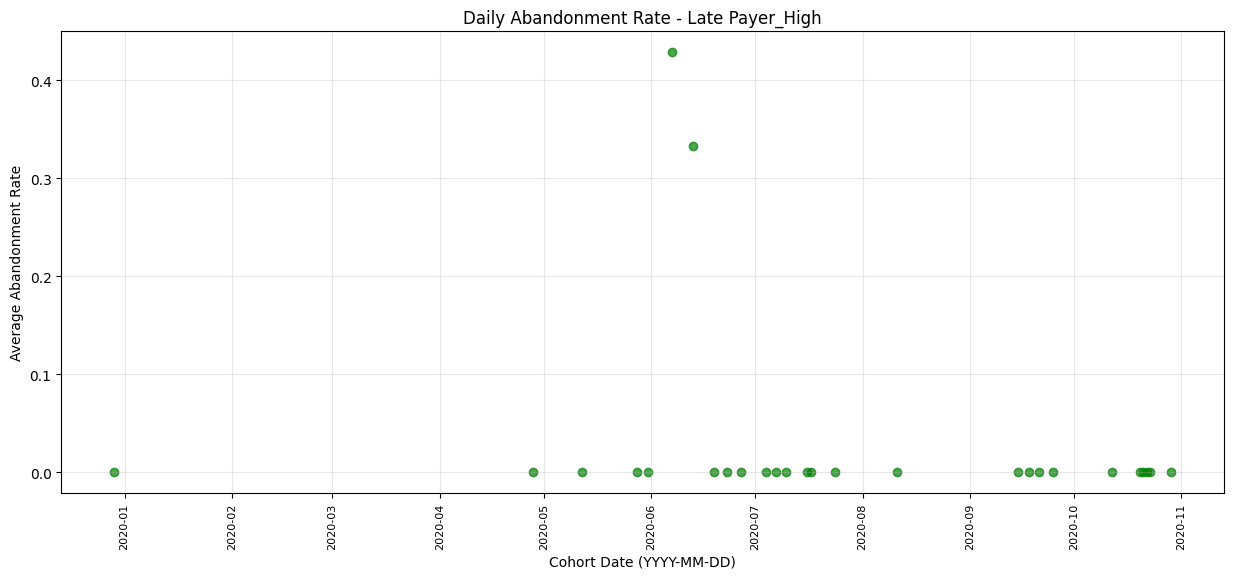

 Gráfico generado para: Late Payer_High

🔹 Generando gráfico de dispersión para: On-time Payer_Low


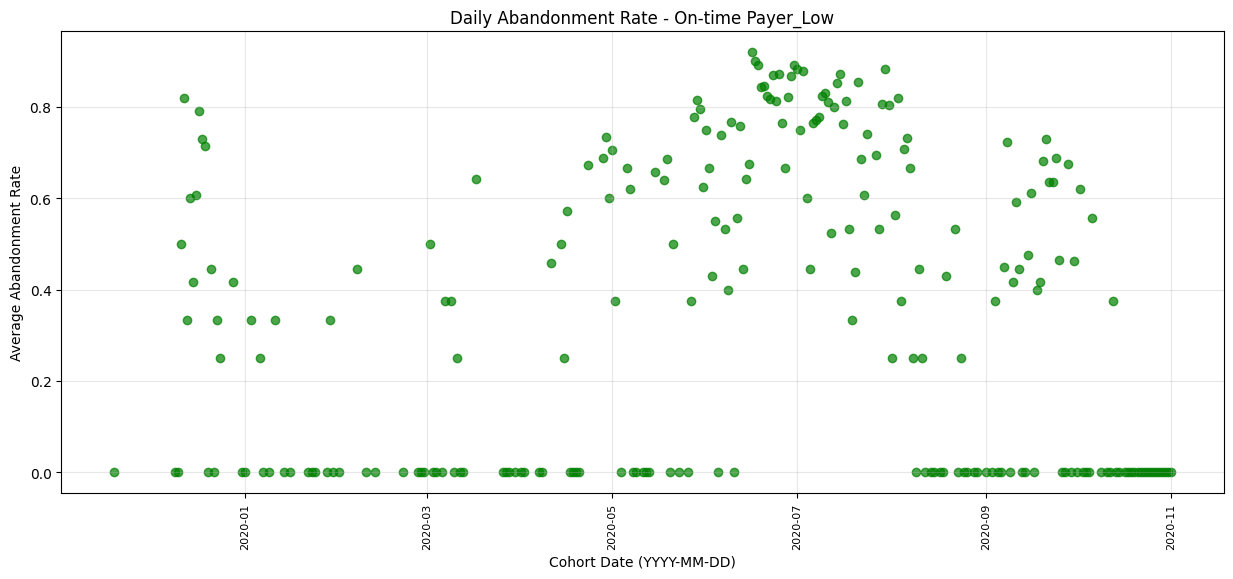

 Gráfico generado para: On-time Payer_Low

🔹 Generando gráfico de dispersión para: On-time Payer_High


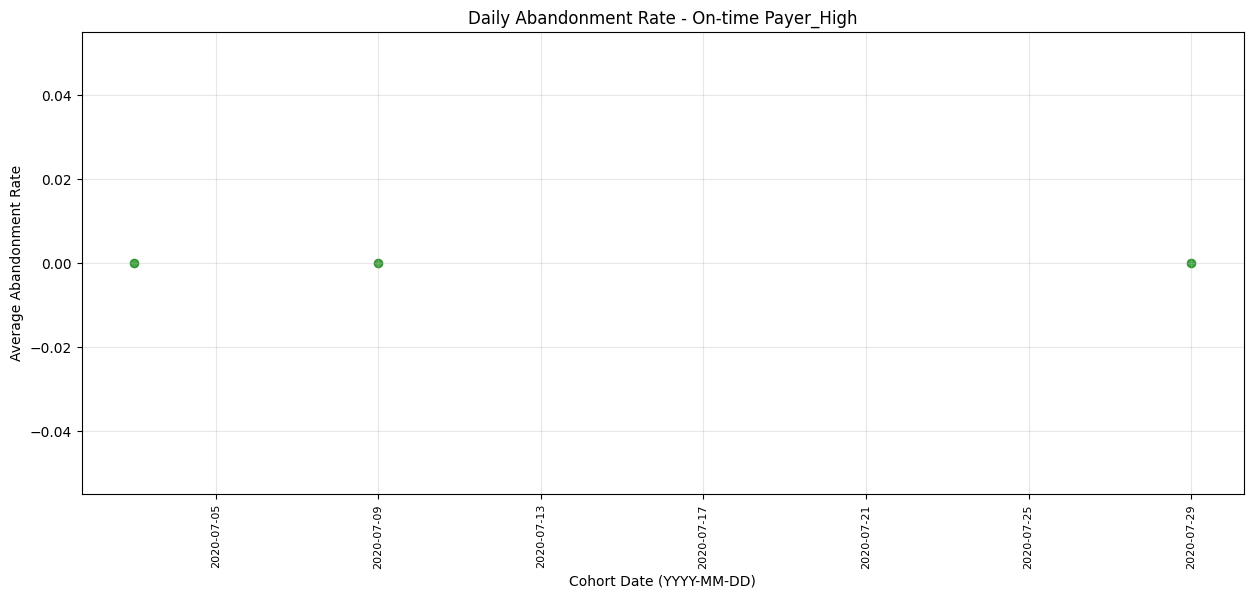

 Gráfico generado para: On-time Payer_High



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

for key, df_churn in sub_retention.items():
    print(f" Generando gráfico de dispersión para: {key}")

    df_churn["cohort_d"] = pd.to_datetime(df_churn["cohort_d"])

    # Calcular la tasa de abandono
    df_daily_mean = df_churn.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
        Mean_Abandonment_Rate=("Retention_Rate", lambda x: 1 - x.mean())  # 1 - Retention Rate
    ).reset_index()

    # Crear gráfico de dispersión con color verde
    plt.figure(figsize=(15, 6))
    plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Mean_Abandonment_Rate"], alpha=0.7, color="green")

    plt.title(f"Daily Abandonment Rate - {key}")
    plt.xlabel("Cohort Date (YYYY-MM-DD)")
    plt.ylabel("Average Abandonment Rate")
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(alpha=0.3)
    plt.show()

    print(f" Gráfico generado para: {key}\n")


Evaluando regresión para: Segmento - Defaulter_Low
Grado 3 - RMSE Train: 0.2794, R² Train: 0.3428, RMSE Test: 0.3212, R² Test: 0.0573, Diferencia R²: 0.2856
Grado 5 - RMSE Train: 0.2759, R² Train: 0.3592, RMSE Test: 0.3176, R² Test: 0.0781, Diferencia R²: 0.2811
Grado 7 - RMSE Train: 0.2685, R² Train: 0.3931, RMSE Test: 0.2945, R² Test: 0.2074, Diferencia R²: 0.1858
Grado 9 - RMSE Train: 0.2557, R² Train: 0.4496, RMSE Test: 0.2738, R² Test: 0.3149, Diferencia R²: 0.1347
Grado 10 - RMSE Train: 0.2461, R² Train: 0.4899, RMSE Test: 0.2648, R² Test: 0.3591, Diferencia R²: 0.1308
Grado 11 - RMSE Train: 0.2461, R² Train: 0.4902, RMSE Test: 0.2638, R² Test: 0.3640, Diferencia R²: 0.1261
 Mejor modelo: Grado 11 - R² Test: 0.3640


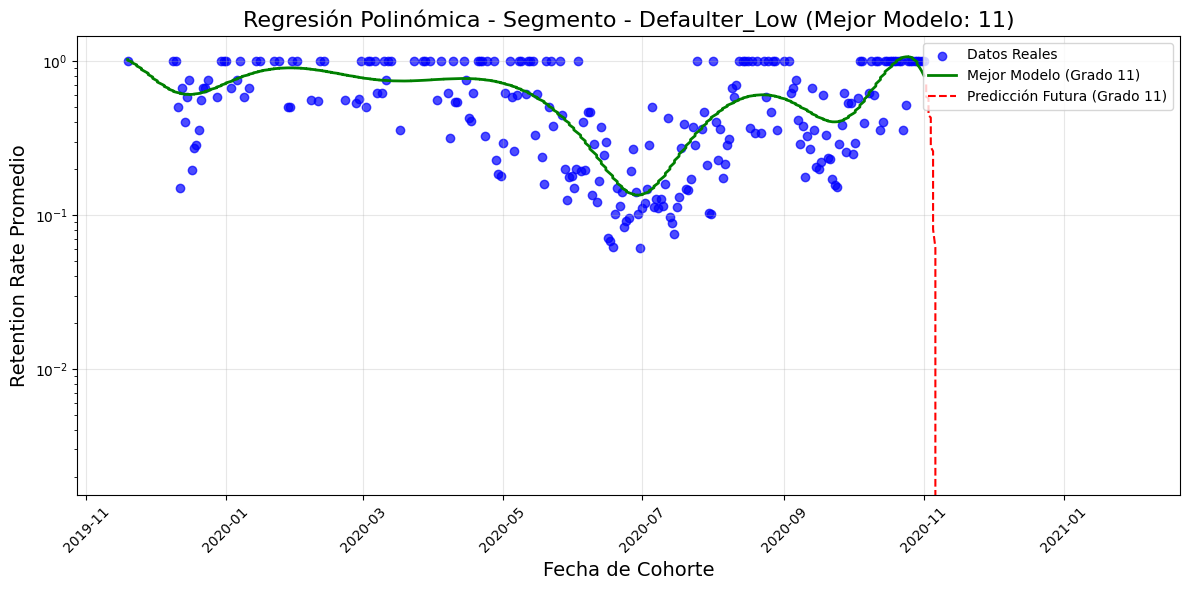

Evaluando regresión para: Segmento - Defaulter_High
Grado 3 - RMSE Train: 0.2749, R² Train: 0.2934, RMSE Test: 0.2874, R² Test: 0.1883, Diferencia R²: 0.1051
Grado 5 - RMSE Train: 0.2601, R² Train: 0.3672, RMSE Test: 0.2816, R² Test: 0.2207, Diferencia R²: 0.1465
Grado 7 - RMSE Train: 0.2480, R² Train: 0.4245, RMSE Test: 0.2793, R² Test: 0.2337, Diferencia R²: 0.1908
Grado 9 - RMSE Train: 0.2363, R² Train: 0.4777, RMSE Test: 0.2767, R² Test: 0.2476, Diferencia R²: 0.2301
Grado 10 - RMSE Train: 0.2353, R² Train: 0.4821, RMSE Test: 0.2739, R² Test: 0.2629, Diferencia R²: 0.2192
Grado 11 - RMSE Train: 0.2353, R² Train: 0.4823, RMSE Test: 0.2731, R² Test: 0.2673, Diferencia R²: 0.2150
 Mejor modelo: Grado 11 - R² Test: 0.2673


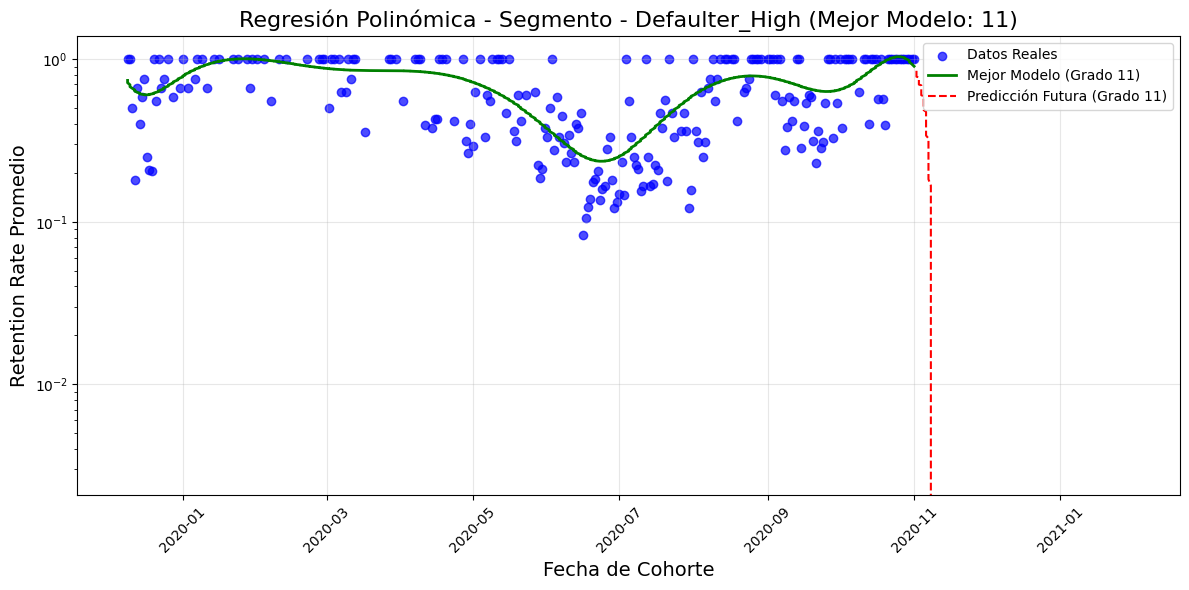

Evaluando regresión para: Segmento - Late Payer_Low
Grado 3 - RMSE Train: 0.2597, R² Train: 0.4247, RMSE Test: 0.2781, R² Test: 0.0427, Diferencia R²: 0.3821
Grado 5 - RMSE Train: 0.2514, R² Train: 0.4609, RMSE Test: 0.2750, R² Test: 0.0642, Diferencia R²: 0.3967
Grado 7 - RMSE Train: 0.2433, R² Train: 0.4952, RMSE Test: 0.2671, R² Test: 0.1168, Diferencia R²: 0.3784
Grado 9 - RMSE Train: 0.2333, R² Train: 0.5359, RMSE Test: 0.2595, R² Test: 0.1668, Diferencia R²: 0.3692
Grado 10 - RMSE Train: 0.2322, R² Train: 0.5404, RMSE Test: 0.2576, R² Test: 0.1786, Diferencia R²: 0.3618
Grado 11 - RMSE Train: 0.2295, R² Train: 0.5509, RMSE Test: 0.2529, R² Test: 0.2085, Diferencia R²: 0.3424
 Mejor modelo: Grado 11 - R² Test: 0.2085


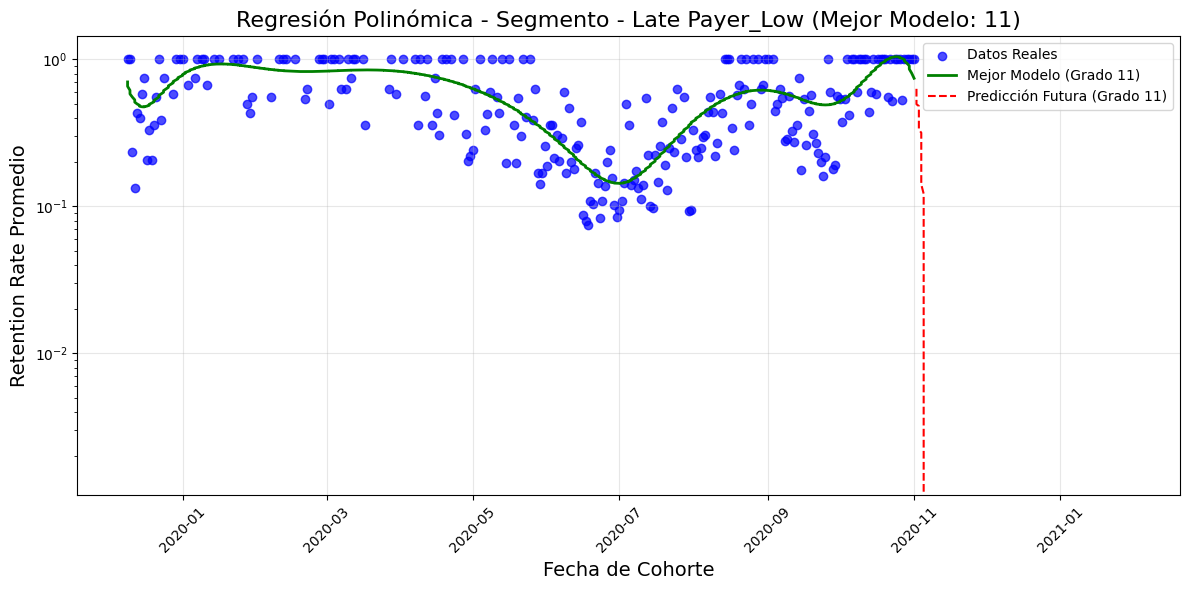

Evaluando regresión para: Segmento - Late Payer_High
Grado 3 - RMSE Train: 0.1019, R² Train: 0.1844, RMSE Test: 0.8382, R² Test: 0.0000, Diferencia R²: 0.1844
Grado 5 - RMSE Train: 0.0962, R² Train: 0.2723, RMSE Test: 2.3793, R² Test: 0.0000, Diferencia R²: 0.2723
Grado 7 - RMSE Train: 0.0867, R² Train: 0.4097, RMSE Test: 342.7714, R² Test: 0.0000, Diferencia R²: 0.4097
Grado 9 - RMSE Train: 0.0807, R² Train: 0.4880, RMSE Test: 8443.6896, R² Test: 0.0000, Diferencia R²: 0.4880
Grado 10 - RMSE Train: 0.0675, R² Train: 0.6417, RMSE Test: 92955.3942, R² Test: 0.0000, Diferencia R²: 0.6417
Grado 11 - RMSE Train: 0.0583, R² Train: 0.7326, RMSE Test: 411379.8564, R² Test: 0.0000, Diferencia R²: 0.7326
 Mejor modelo: Grado 3 - R² Test: 0.0000


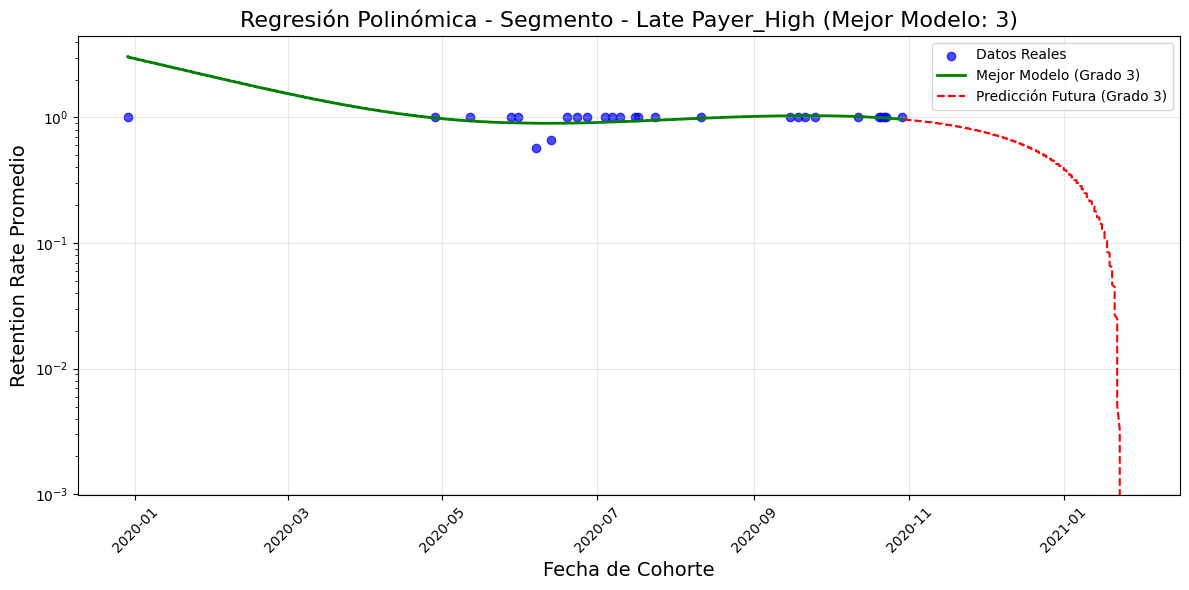

Evaluando regresión para: Segmento - On-time Payer_Low
Grado 3 - RMSE Train: 0.2720, R² Train: 0.3298, RMSE Test: 0.2763, R² Test: 0.3383, Diferencia R²: 0.0085
Grado 5 - RMSE Train: 0.2566, R² Train: 0.4035, RMSE Test: 0.2687, R² Test: 0.3741, Diferencia R²: 0.0294
Grado 7 - RMSE Train: 0.2514, R² Train: 0.4276, RMSE Test: 0.2604, R² Test: 0.4121, Diferencia R²: 0.0155
Grado 9 - RMSE Train: 0.2414, R² Train: 0.4721, RMSE Test: 0.2470, R² Test: 0.4711, Diferencia R²: 0.0010
Grado 10 - RMSE Train: 0.2316, R² Train: 0.5142, RMSE Test: 0.2464, R² Test: 0.4737, Diferencia R²: 0.0405
Grado 11 - RMSE Train: 0.2293, R² Train: 0.5238, RMSE Test: 0.2495, R² Test: 0.4604, Diferencia R²: 0.0634
 Mejor modelo: Grado 10 - R² Test: 0.4737


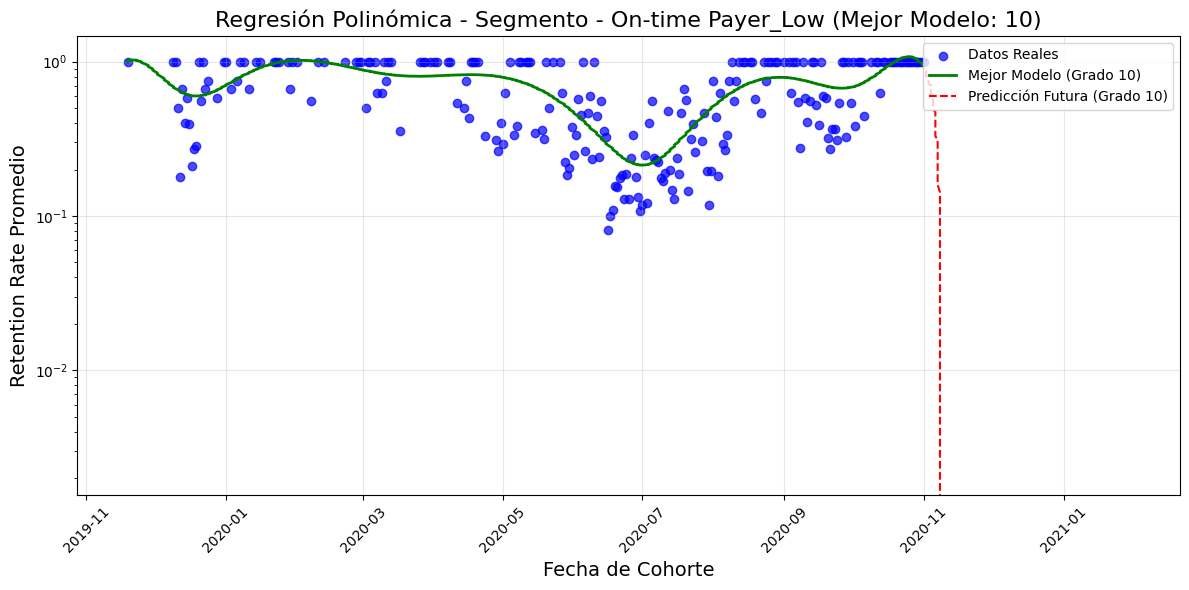

Evaluando regresión para: Segmento - On-time Payer_High
 Segmento - On-time Payer_High tiene muy pocos datos para aplicar regresión.


In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

# Función para aplicar regresión polinómica a un subdataset
def apply_regression(df_retention, title):
    print(f"Evaluando regresión para: {title}")

    # Convertir cohort_d a datetime
    df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

    # Agrupar por cohorte diaria y calcular la media de la Retention Rate
    df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
        Mean_Retention_Rate=("Retention_Rate", "mean")
    ).reset_index()

    # Eliminar valores NaN
    df_daily_mean = df_daily_mean.dropna(subset=["Mean_Retention_Rate"])

    # Convertir la fecha a un número ordinal
    df_daily_mean["Date_Num"] = df_daily_mean["cohort_d"].map(pd.Timestamp.toordinal)

    # Determinar el origen dinámico basado en el primer día de los datos
    origin_date = df_daily_mean["cohort_d"].min()

    # Separar en entrenamiento y prueba
    X = df_daily_mean[['Date_Num']].values
    y = df_daily_mean['Mean_Retention_Rate'].values

    if len(X) < 10:  # Si hay muy pocos datos, evitar errores
        print(f" {title} tiene muy pocos datos para aplicar regresión.")
        return

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Generar un rango continuo de fechas para la predicción
    date_range = np.linspace(df_daily_mean['Date_Num'].min(), df_daily_mean['Date_Num'].max(), 500).reshape(-1, 1)

    # Extender fechas para predicciones futuras
    additional_days = 90  # Extender predicción por 90 días
    future_dates = np.linspace(df_daily_mean['Date_Num'].max() + 1, df_daily_mean['Date_Num'].max() + additional_days, 1000).reshape(-1, 1)

    results = []

    for degree in [3, 5, 7, 9, 10, 11]:
     
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_scaled = scaler.transform(X)
        date_range_scaled = scaler.transform(date_range)
        future_dates_scaled = scaler.transform(future_dates)

        # Transformar las fechas en base al modelo polinómico
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train_scaled)
        X_test_poly = poly.transform(X_test_scaled)
        X_poly = poly.transform(X_scaled)
        date_range_poly = poly.transform(date_range_scaled)
        future_dates_poly = poly.transform(future_dates_scaled)

        # Entrenar el modelo de regresión polinómica
        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        # Predicción en entrenamiento y test
        y_train_pred = model.predict(X_train_poly)
        y_test_pred = model.predict(X_test_poly)
        y_pred_range = model.predict(date_range_poly)
        y_future_pred = model.predict(future_dates_poly)

        # Evaluación
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        r2_train = r2_score(y_train, y_train_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        r2_test = r2_score(y_test, y_test_pred)
        r2_diff = abs(r2_train - r2_test)

        results.append((degree, rmse_train, r2_train, rmse_test, r2_test, r2_diff, y_pred_range, y_future_pred))     
        print(f"Grado {degree} - RMSE Train: {rmse_train:.4f}, R² Train: {r2_train:.4f}, RMSE Test: {rmse_test:.4f}, R² Test: {r2_test:.4f}, Diferencia R²: {r2_diff:.4f}")

    # Seleccionar el modelo con el mejor R² en test
    best_model = max(results, key=lambda x: x[4])  # Selecciona el mayor R² Test
    best_degree, _, _, _, best_r2_test, _, best_y_pred_range, best_y_future_pred = best_model

    print(f" Mejor modelo: Grado {best_degree} - R² Test: {best_r2_test:.4f}")

    # Crear gráfico con SOLO el mejor modelo
    plt.figure(figsize=(12, 6))
    plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Mean_Retention_Rate"], alpha=0.7, label="Datos Reales", color="blue")

    # Graficar la mejor curva de ajuste
    plt.plot([origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in date_range.flatten()], 
             best_y_pred_range, label=f'Mejor Modelo (Grado {best_degree})', linewidth=2, color="green")

    # Graficar la mejor extrapolación futura
    plt.plot([origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in future_dates.flatten()], 
             best_y_future_pred, linestyle='dashed', color="red", label=f'Predicción Futura (Grado {best_degree})')

    # Configurar el gráfico
    plt.title(f'Regresión Polinómica - {title} (Mejor Modelo: {best_degree})', fontsize=16)
    plt.xlabel('Fecha de Cohorte', fontsize=14)
    plt.ylabel('Retention Rate Promedio', fontsize=14)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Aplicar regresión a todos los subdatasets en sub_retention
for key, df_churn in sub_retention.items():
    apply_regression(df_churn, f"Segmento - {key}")


Evaluando regresión para: Segmento - Defaulter_Low
Grado 3 - RMSE Train: 0.2794, R² Train: 0.3428, RMSE Test: 0.3212, R² Test: 0.0573, Diferencia R²: 0.2856
Grado 5 - RMSE Train: 0.2759, R² Train: 0.3592, RMSE Test: 0.3176, R² Test: 0.0781, Diferencia R²: 0.2811
Grado 7 - RMSE Train: 0.2685, R² Train: 0.3931, RMSE Test: 0.2945, R² Test: 0.2074, Diferencia R²: 0.1858
Grado 9 - RMSE Train: 0.2557, R² Train: 0.4496, RMSE Test: 0.2738, R² Test: 0.3149, Diferencia R²: 0.1347
Grado 10 - RMSE Train: 0.2461, R² Train: 0.4899, RMSE Test: 0.2648, R² Test: 0.3591, Diferencia R²: 0.1308
Grado 11 - RMSE Train: 0.2461, R² Train: 0.4902, RMSE Test: 0.2638, R² Test: 0.3640, Diferencia R²: 0.1261
 Mejor modelo: Grado 11 - R² Test: 0.3640


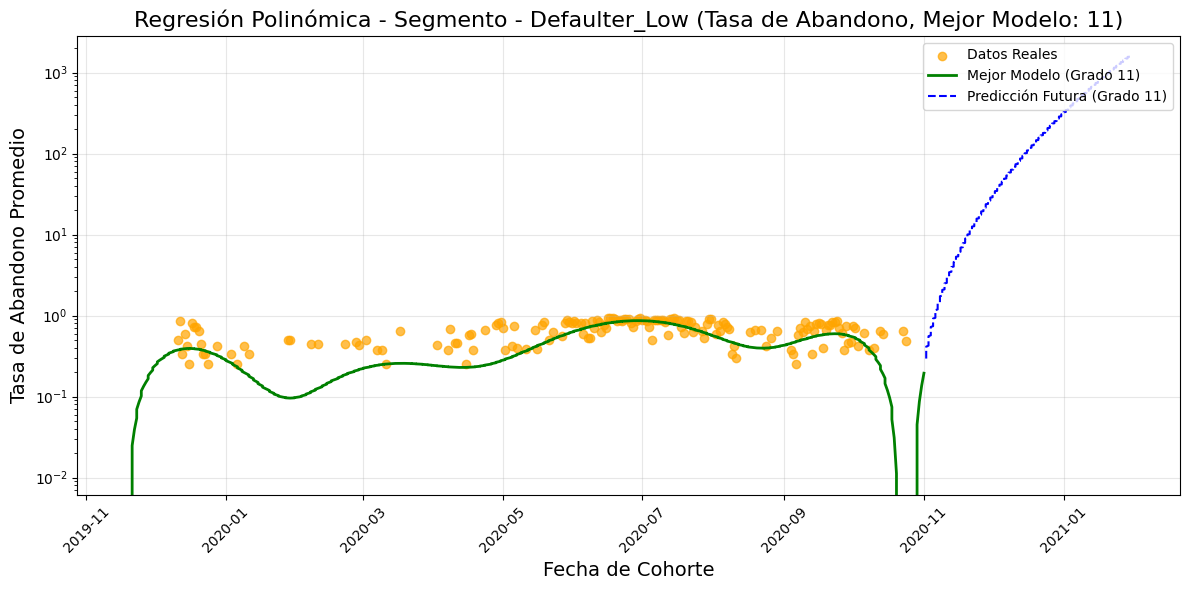

Evaluando regresión para: Segmento - Defaulter_High
Grado 3 - RMSE Train: 0.2749, R² Train: 0.2934, RMSE Test: 0.2874, R² Test: 0.1883, Diferencia R²: 0.1051
Grado 5 - RMSE Train: 0.2601, R² Train: 0.3672, RMSE Test: 0.2816, R² Test: 0.2207, Diferencia R²: 0.1465
Grado 7 - RMSE Train: 0.2480, R² Train: 0.4245, RMSE Test: 0.2793, R² Test: 0.2337, Diferencia R²: 0.1908
Grado 9 - RMSE Train: 0.2363, R² Train: 0.4777, RMSE Test: 0.2767, R² Test: 0.2476, Diferencia R²: 0.2301
Grado 10 - RMSE Train: 0.2353, R² Train: 0.4821, RMSE Test: 0.2739, R² Test: 0.2629, Diferencia R²: 0.2192
Grado 11 - RMSE Train: 0.2353, R² Train: 0.4823, RMSE Test: 0.2731, R² Test: 0.2673, Diferencia R²: 0.2150
 Mejor modelo: Grado 11 - R² Test: 0.2673


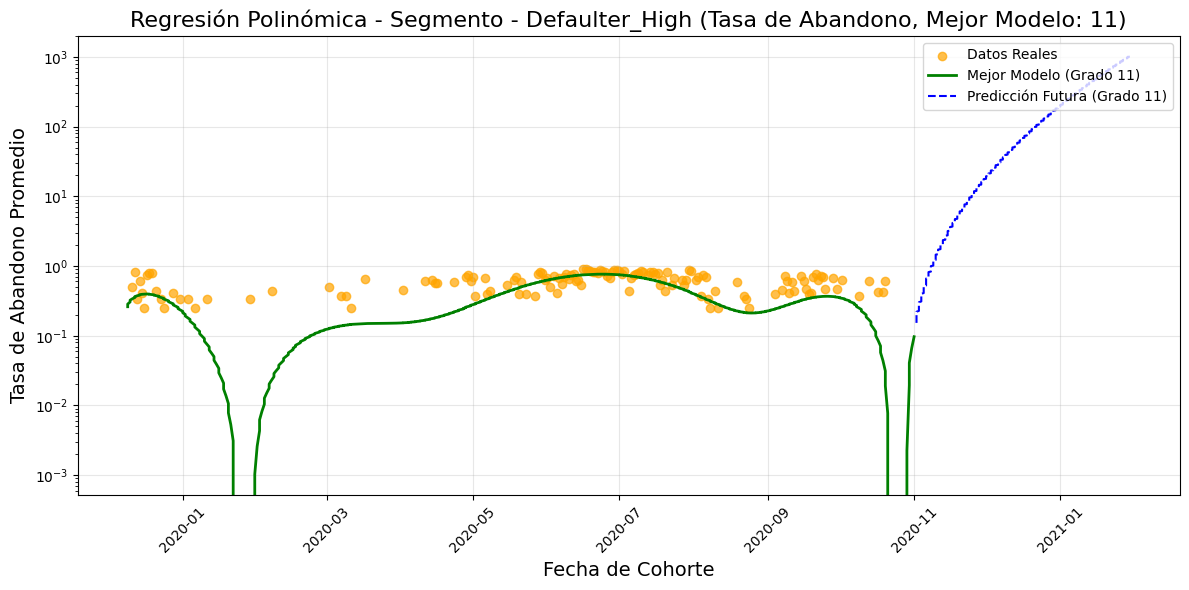

Evaluando regresión para: Segmento - Late Payer_Low
Grado 3 - RMSE Train: 0.2597, R² Train: 0.4247, RMSE Test: 0.2781, R² Test: 0.0427, Diferencia R²: 0.3821
Grado 5 - RMSE Train: 0.2514, R² Train: 0.4609, RMSE Test: 0.2750, R² Test: 0.0642, Diferencia R²: 0.3967
Grado 7 - RMSE Train: 0.2433, R² Train: 0.4952, RMSE Test: 0.2671, R² Test: 0.1168, Diferencia R²: 0.3784
Grado 9 - RMSE Train: 0.2333, R² Train: 0.5359, RMSE Test: 0.2595, R² Test: 0.1668, Diferencia R²: 0.3692
Grado 10 - RMSE Train: 0.2322, R² Train: 0.5404, RMSE Test: 0.2576, R² Test: 0.1786, Diferencia R²: 0.3618
Grado 11 - RMSE Train: 0.2295, R² Train: 0.5509, RMSE Test: 0.2529, R² Test: 0.2085, Diferencia R²: 0.3424
 Mejor modelo: Grado 11 - R² Test: 0.2085


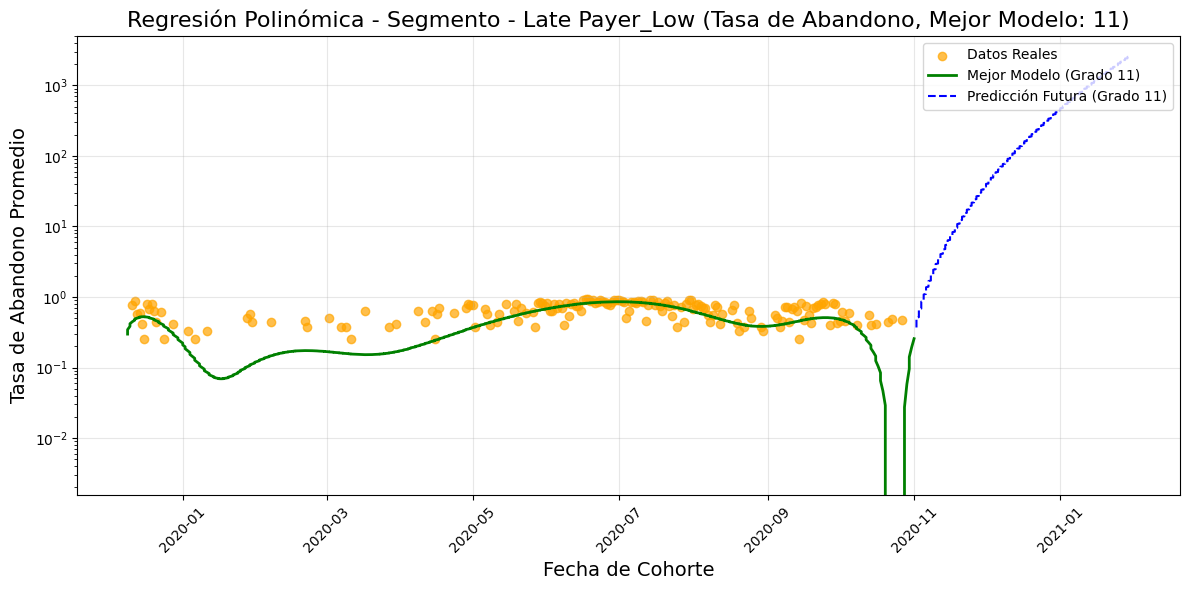

Evaluando regresión para: Segmento - Late Payer_High
Grado 3 - RMSE Train: 0.1019, R² Train: 0.1844, RMSE Test: 0.8382, R² Test: 0.0000, Diferencia R²: 0.1844
Grado 5 - RMSE Train: 0.0962, R² Train: 0.2723, RMSE Test: 2.3793, R² Test: 0.0000, Diferencia R²: 0.2723
Grado 7 - RMSE Train: 0.0867, R² Train: 0.4097, RMSE Test: 342.7714, R² Test: 0.0000, Diferencia R²: 0.4097
Grado 9 - RMSE Train: 0.0807, R² Train: 0.4880, RMSE Test: 8443.6896, R² Test: 0.0000, Diferencia R²: 0.4880
Grado 10 - RMSE Train: 0.0675, R² Train: 0.6417, RMSE Test: 92955.3942, R² Test: 0.0000, Diferencia R²: 0.6417
Grado 11 - RMSE Train: 0.0583, R² Train: 0.7326, RMSE Test: 411379.8564, R² Test: 0.0000, Diferencia R²: 0.7326
 Mejor modelo: Grado 3 - R² Test: 0.0000


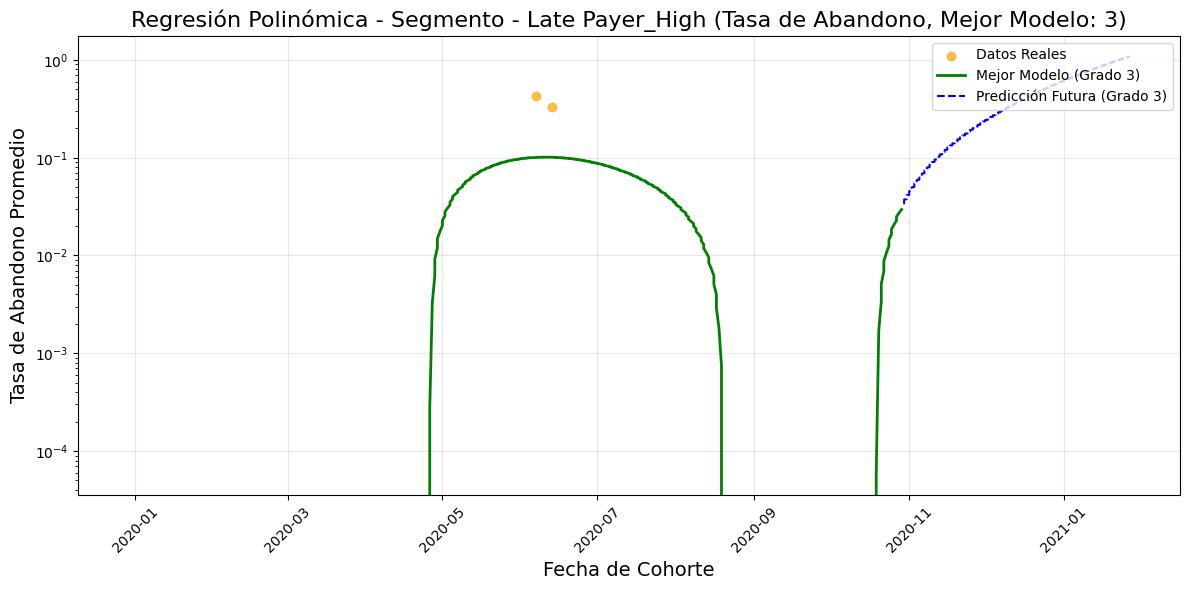

Evaluando regresión para: Segmento - On-time Payer_Low
Grado 3 - RMSE Train: 0.2720, R² Train: 0.3298, RMSE Test: 0.2763, R² Test: 0.3383, Diferencia R²: 0.0085
Grado 5 - RMSE Train: 0.2566, R² Train: 0.4035, RMSE Test: 0.2687, R² Test: 0.3741, Diferencia R²: 0.0294
Grado 7 - RMSE Train: 0.2514, R² Train: 0.4276, RMSE Test: 0.2604, R² Test: 0.4121, Diferencia R²: 0.0155
Grado 9 - RMSE Train: 0.2414, R² Train: 0.4721, RMSE Test: 0.2470, R² Test: 0.4711, Diferencia R²: 0.0010
Grado 10 - RMSE Train: 0.2316, R² Train: 0.5142, RMSE Test: 0.2464, R² Test: 0.4737, Diferencia R²: 0.0405
Grado 11 - RMSE Train: 0.2293, R² Train: 0.5238, RMSE Test: 0.2495, R² Test: 0.4604, Diferencia R²: 0.0634
 Mejor modelo: Grado 10 - R² Test: 0.4737


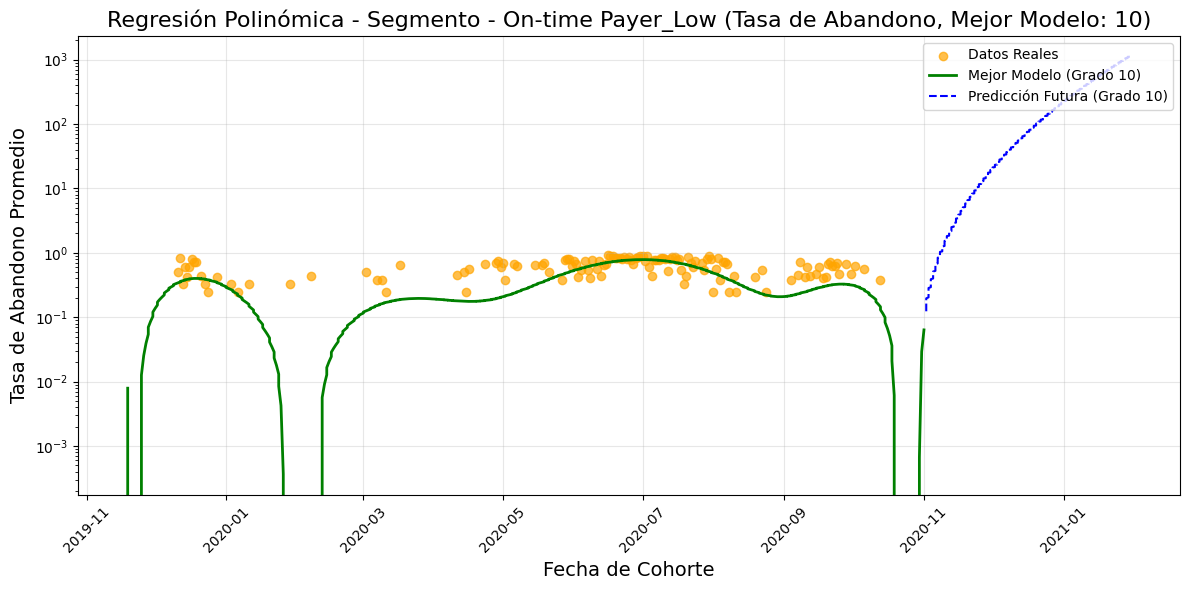

Evaluando regresión para: Segmento - On-time Payer_High
 Segmento - On-time Payer_High tiene muy pocos datos para aplicar regresión.


In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

# Función para aplicar regresión polinómica a la tasa de abandono
def apply_regression_abandonment(df_retention, title):
    print(f"Evaluando regresión para: {title}")

    df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

    # Agrupar por cohorte diaria y calcular la media de la Tasa de Abandono
    df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
        Mean_Abandonment_Rate=("Retention_Rate", lambda x: 1 - x.mean())  # 1 - Retention Rate
    ).reset_index()

    df_daily_mean = df_daily_mean.dropna(subset=["Mean_Abandonment_Rate"])

    # Convertir la fecha a un número ordinal
    df_daily_mean["Date_Num"] = df_daily_mean["cohort_d"].map(pd.Timestamp.toordinal)

    origin_date = df_daily_mean["cohort_d"].min()

    # Separar en entrenamiento y prueba
    X = df_daily_mean[['Date_Num']].values
    y = df_daily_mean['Mean_Abandonment_Rate'].values

    if len(X) < 10:
        print(f" {title} tiene muy pocos datos para aplicar regresión.")
        return

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Generar un rango continuo de fechas para la predicción
    date_range = np.linspace(df_daily_mean['Date_Num'].min(), df_daily_mean['Date_Num'].max(), 500).reshape(-1, 1)
    additional_days = 90  
    future_dates = np.linspace(df_daily_mean['Date_Num'].max() + 1, df_daily_mean['Date_Num'].max() + additional_days, 1000).reshape(-1, 1)

    results = []

    for degree in [3, 5, 7, 9, 10, 11]:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_scaled = scaler.transform(X)
        date_range_scaled = scaler.transform(date_range)
        future_dates_scaled = scaler.transform(future_dates)

        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train_scaled)
        X_test_poly = poly.transform(X_test_scaled)
        X_poly = poly.transform(X_scaled)
        date_range_poly = poly.transform(date_range_scaled)
        future_dates_poly = poly.transform(future_dates_scaled)

        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        y_train_pred = model.predict(X_train_poly)
        y_test_pred = model.predict(X_test_poly)
        y_pred_range = model.predict(date_range_poly)
        y_future_pred = model.predict(future_dates_poly)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        r2_train = r2_score(y_train, y_train_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        r2_test = r2_score(y_test, y_test_pred)
        r2_diff = abs(r2_train - r2_test)

        results.append((degree, rmse_train, r2_train, rmse_test, r2_test, r2_diff, y_pred_range, y_future_pred))     
        print(f"Grado {degree} - RMSE Train: {rmse_train:.4f}, R² Train: {r2_train:.4f}, RMSE Test: {rmse_test:.4f}, R² Test: {r2_test:.4f}, Diferencia R²: {r2_diff:.4f}")

    best_model = max(results, key=lambda x: x[4])
    best_degree, _, _, _, best_r2_test, _, best_y_pred_range, best_y_future_pred = best_model

    print(f" Mejor modelo: Grado {best_degree} - R² Test: {best_r2_test:.4f}")

    # Crear gráfico con el mejor modelo
    plt.figure(figsize=(12, 6))
    plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Mean_Abandonment_Rate"], alpha=0.7, label="Datos Reales", color="orange")

    plt.plot([origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in date_range.flatten()], 
             best_y_pred_range, label=f'Mejor Modelo (Grado {best_degree})', linewidth=2, color="green")

    plt.plot([origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in future_dates.flatten()], 
             best_y_future_pred, linestyle='dashed', color="blue", label=f'Predicción Futura (Grado {best_degree})')

    plt.title(f'Regresión Polinómica - {title} (Tasa de Abandono, Mejor Modelo: {best_degree})', fontsize=16)
    plt.xlabel('Fecha de Cohorte', fontsize=14)
    plt.ylabel('Tasa de Abandono Promedio', fontsize=14)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Aplicar regresión de tasa de abandono a todos los subdatasets en sub_retention
for key, df_churn in sub_retention.items():
    apply_regression_abandonment(df_churn, f"Segmento - {key}")


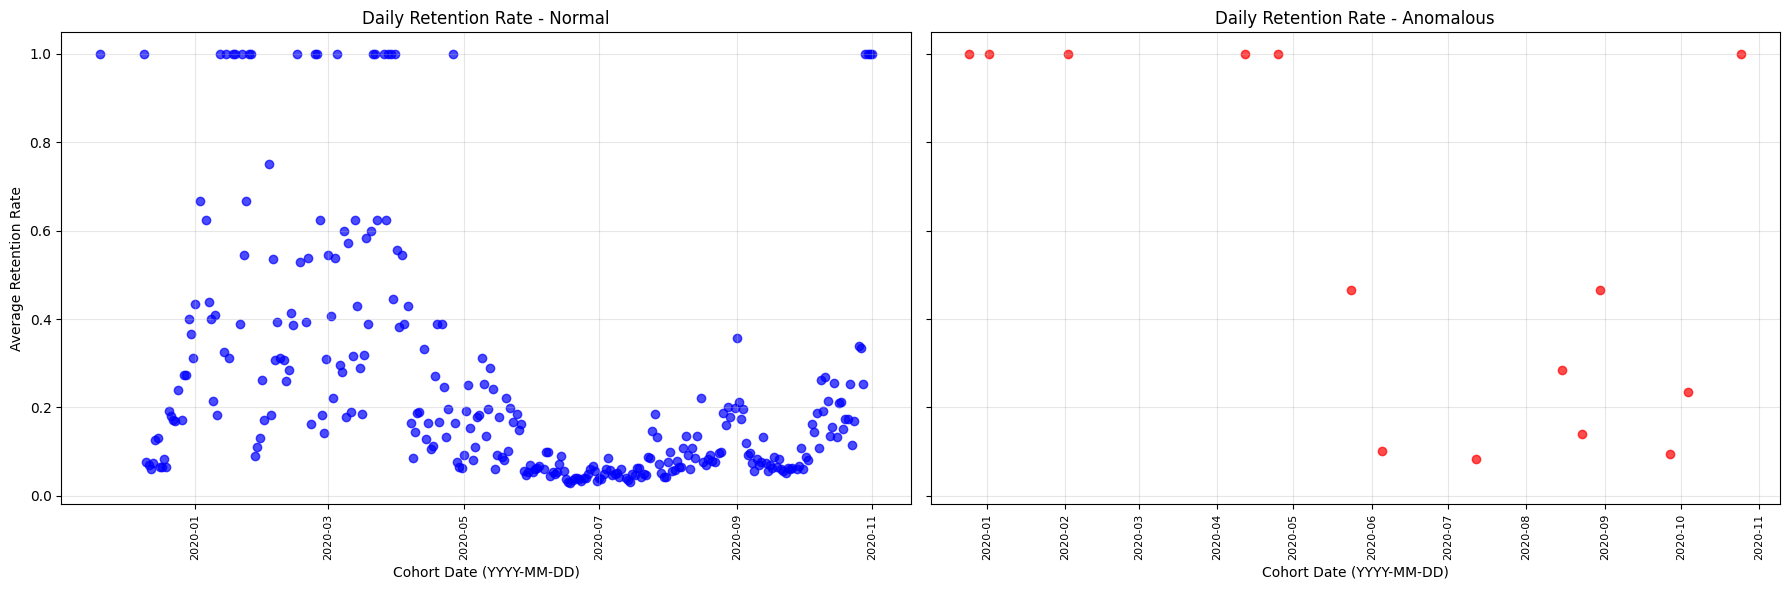

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')



df_churn["cohort_d"] = pd.to_datetime(df_churn["cohort_d"])

df_daily_mean = df_churn.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Retention_Rate=("Retention_Rate", "mean")
).reset_index()
df_daily_mean.sort_values(by='cohort_d', inplace=True)

window_size = 7
df_daily_mean['rolling_mean'] = df_daily_mean['Mean_Retention_Rate'].rolling(
    window=window_size, 
    min_periods=1
).mean()

df_daily_mean['rolling_std'] = df_daily_mean['Mean_Retention_Rate'].rolling(
    window=window_size,
    min_periods=1
).std()

threshold = 2


df_daily_mean['is_anomaly'] = (
    abs(df_daily_mean['Mean_Retention_Rate'] - df_daily_mean['rolling_mean']) 
    > threshold * df_daily_mean['rolling_std']
)
df_normal = df_daily_mean[df_daily_mean['is_anomaly'] == False]
df_anomalous = df_daily_mean[df_daily_mean['is_anomaly'] == True]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharey=True)

ax1.scatter(
    df_normal["cohort_d"], 
    df_normal["Mean_Retention_Rate"], 
    alpha=0.7, 
    color="blue"
)
ax1.set_title("Daily Retention Rate - Normal")
ax1.set_xlabel("Cohort Date (YYYY-MM-DD)")
ax1.set_ylabel("Average Retention Rate")
ax1.tick_params(axis='x', rotation=90, labelsize=8)
ax1.grid(alpha=0.3)


ax2.scatter(
    df_anomalous["cohort_d"], 
    df_anomalous["Mean_Retention_Rate"], 
    alpha=0.7, 
    color="red"
)
ax2.set_title("Daily Retention Rate - Anomalous")
ax2.set_xlabel("Cohort Date (YYYY-MM-DD)")
ax2.tick_params(axis='x', rotation=90, labelsize=8)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


No hay datos para nan | nan
No hay datos para nan | Low
No hay datos para nan | High
No hay datos para Defaulter | nan


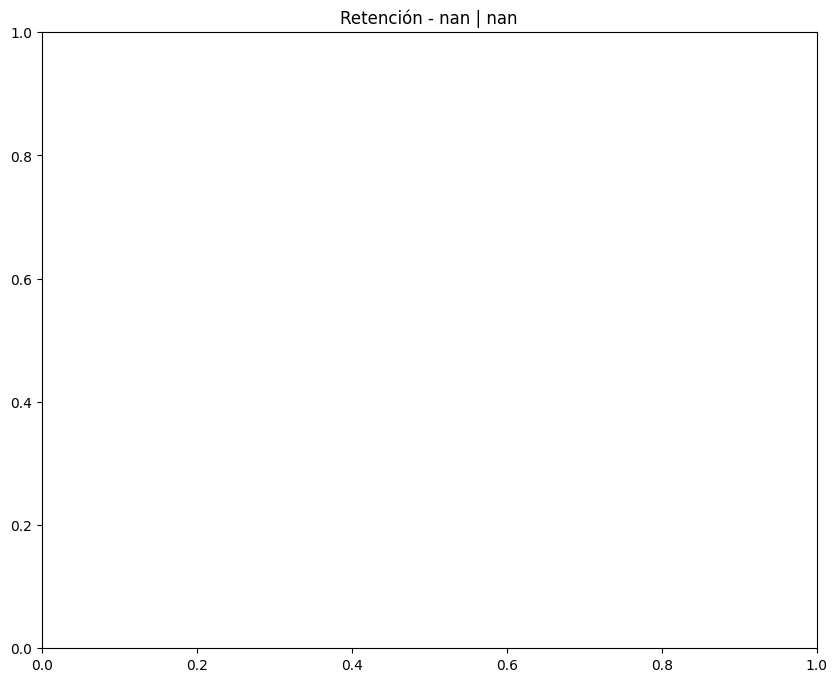

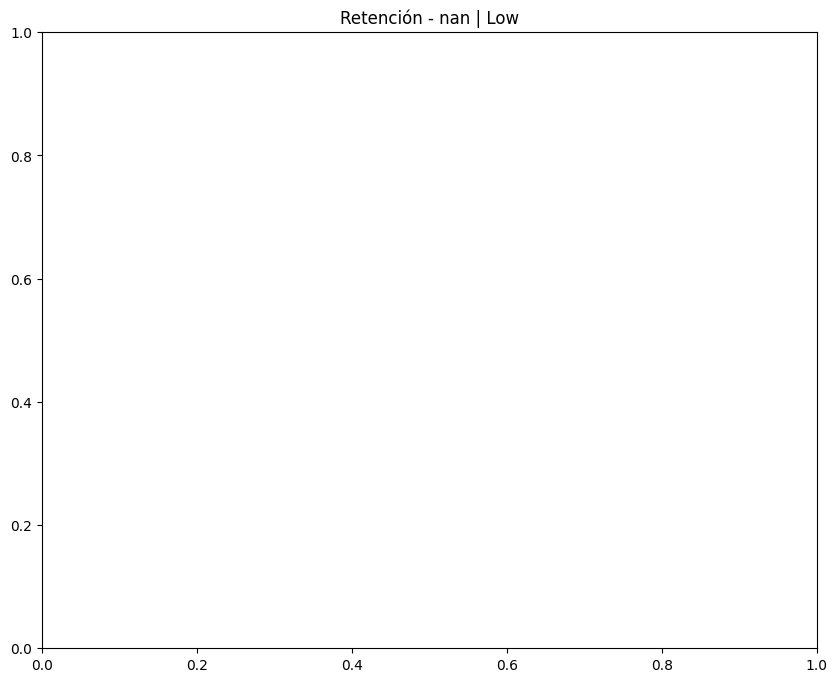

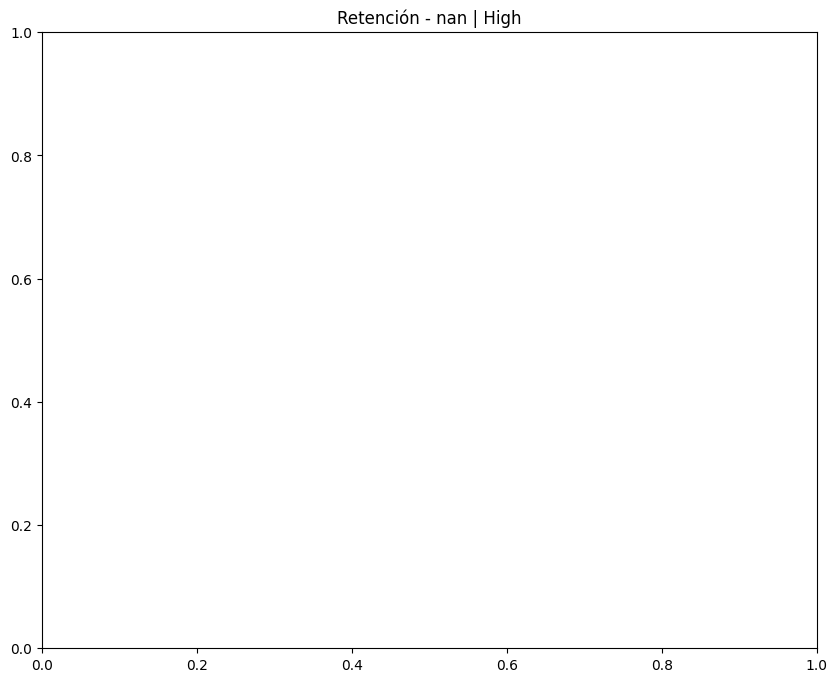

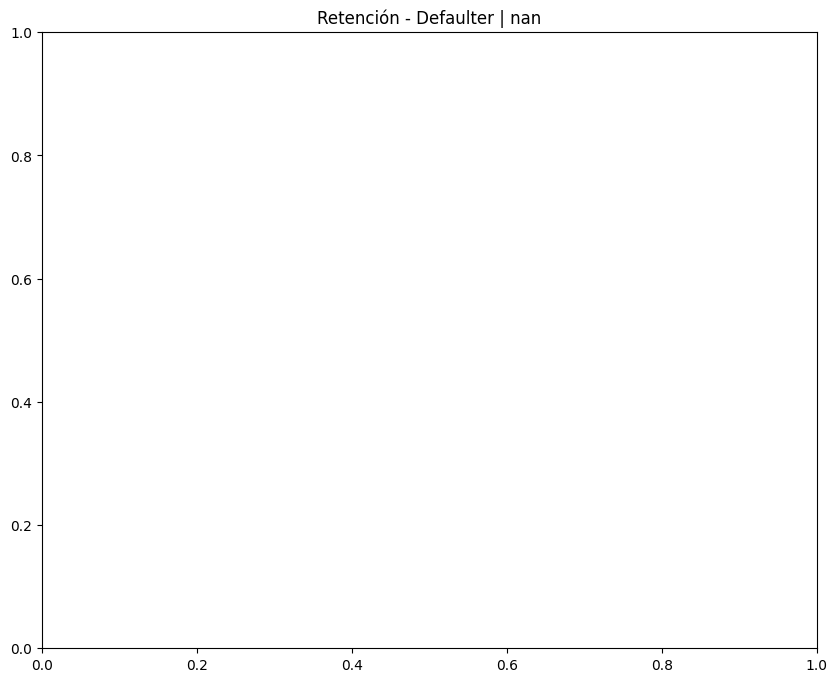

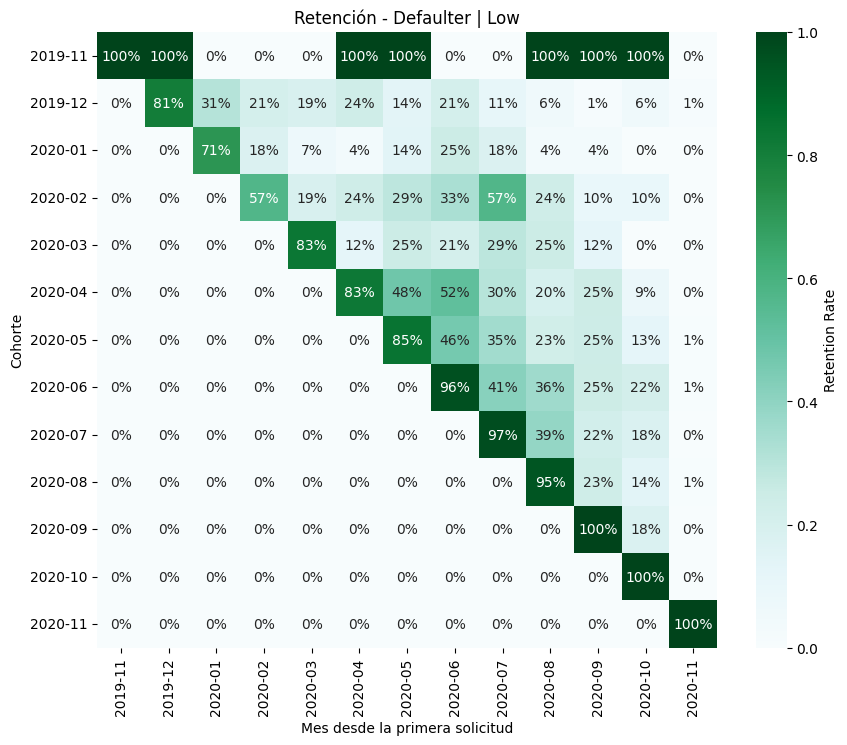

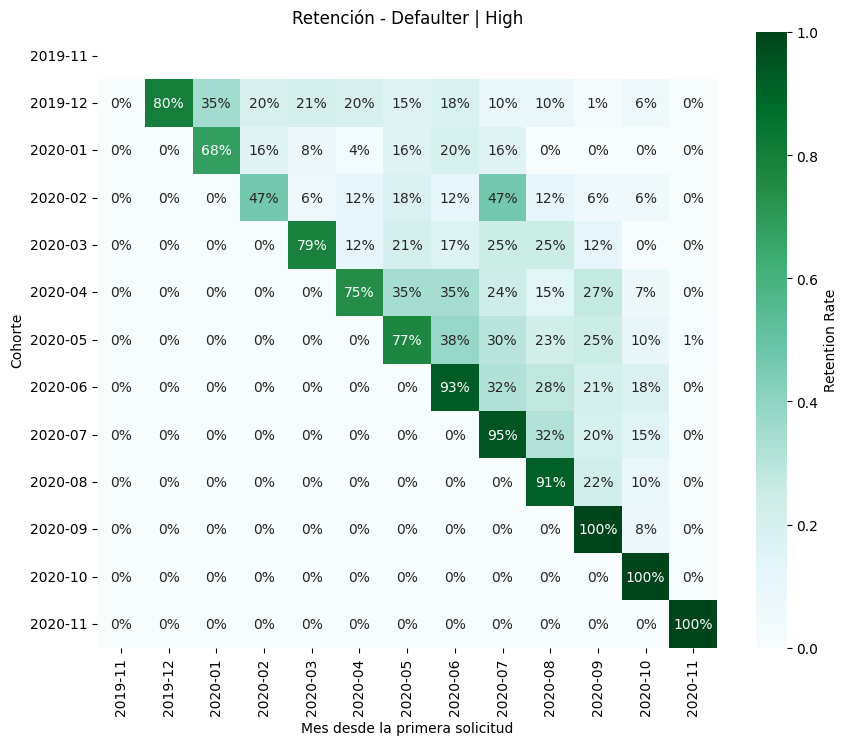

No hay datos para On-time Payer | nan


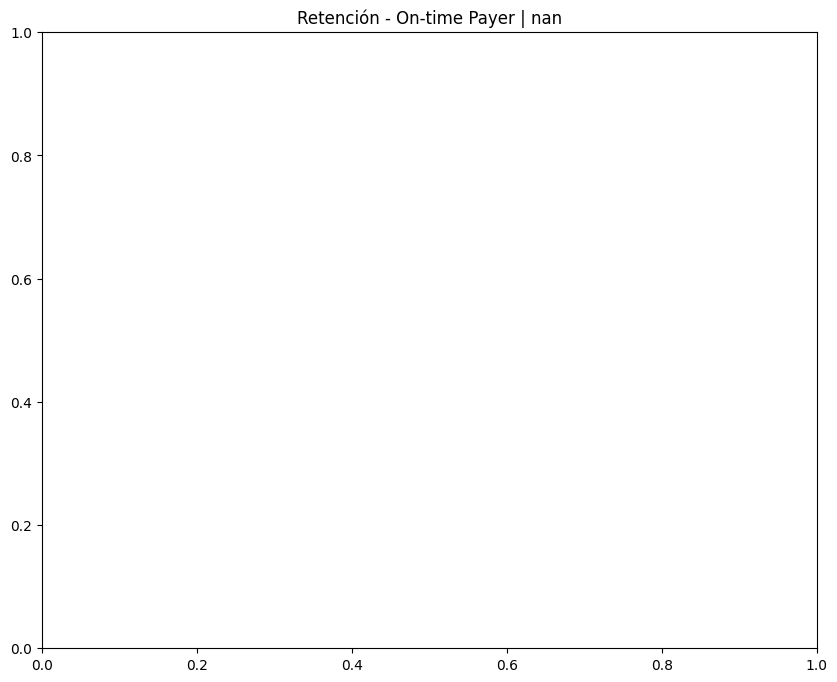

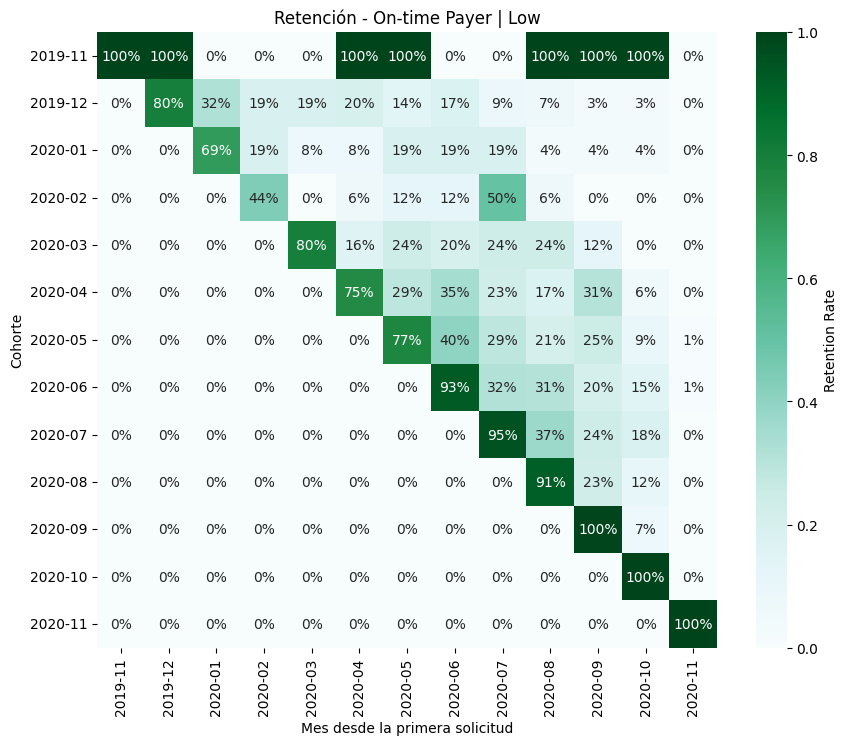

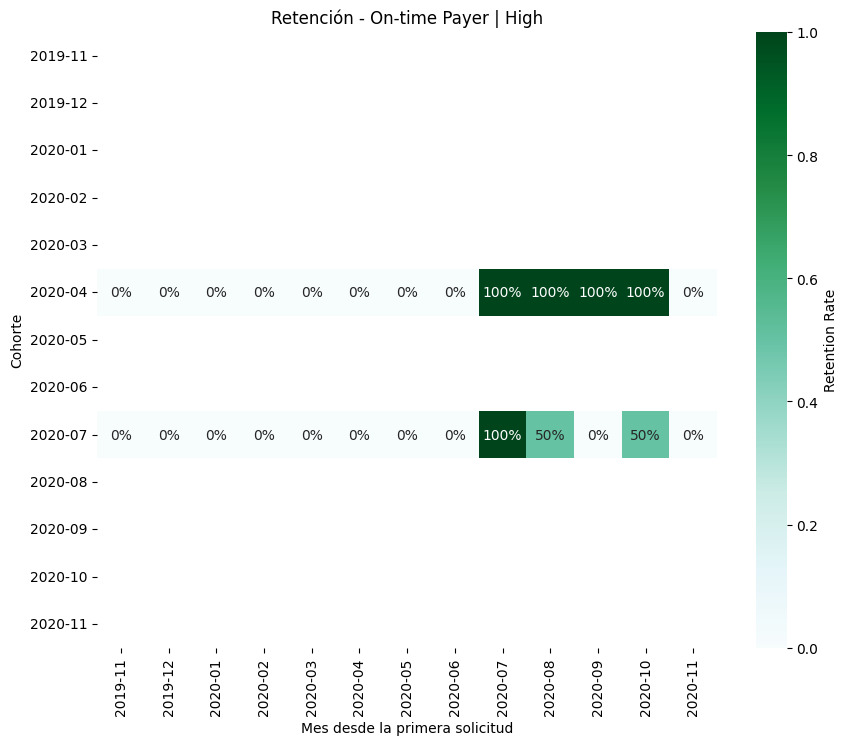

No hay datos para Late Payer | nan


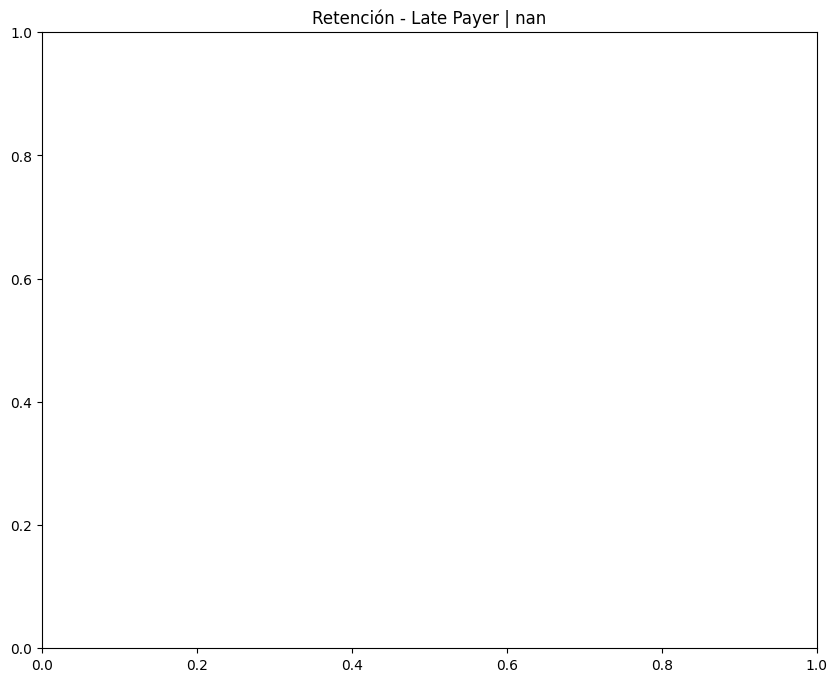

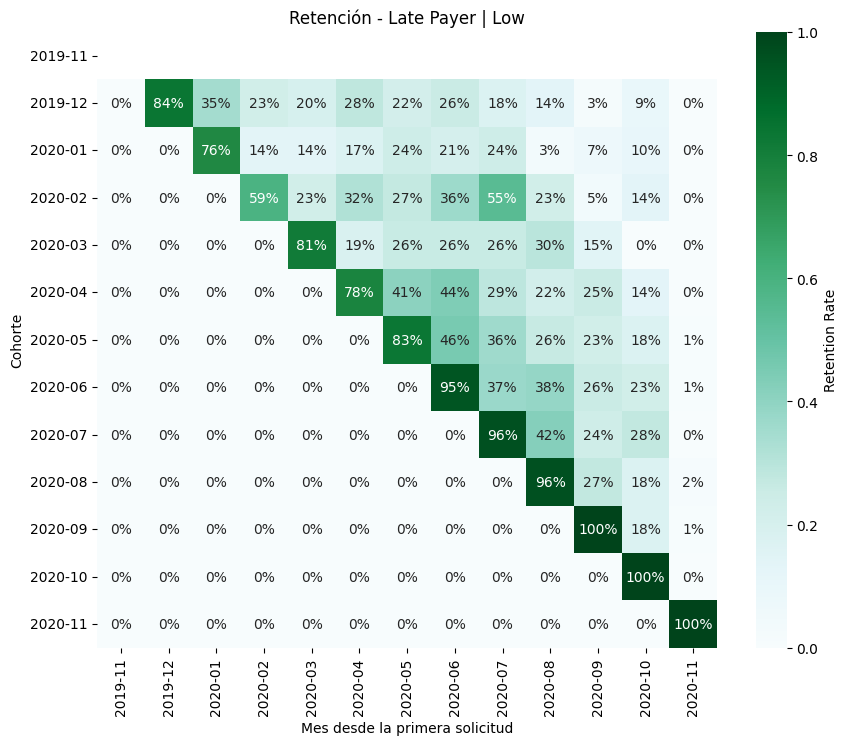

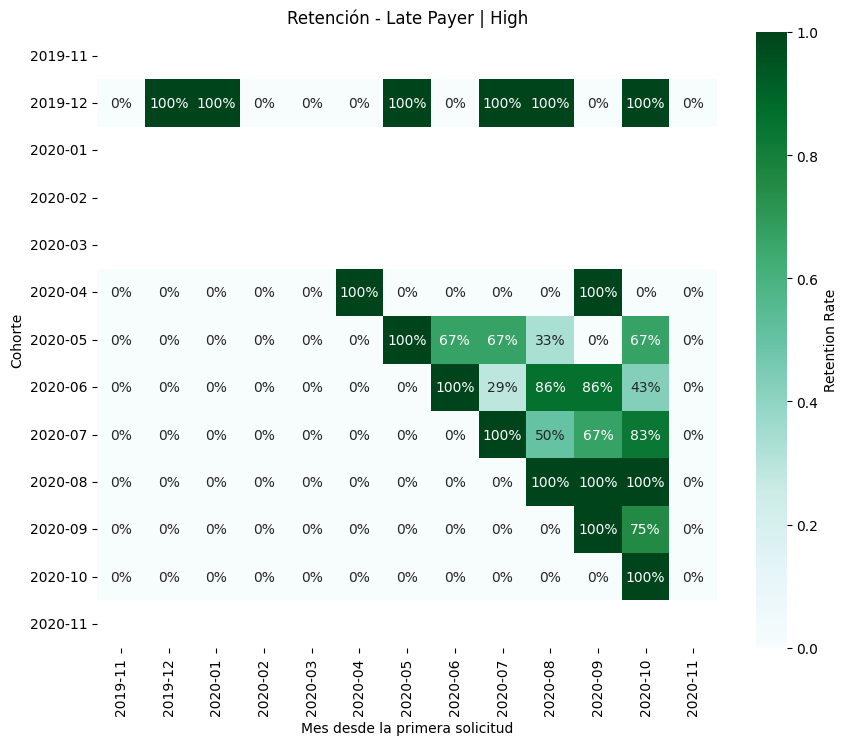

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# **Crear Cohortes en merged_data**
merged_data['created_at'] = pd.to_datetime(merged_data['created_at'])
merged_data['created_at'] = merged_data['created_at'].dt.tz_localize(None)

# **Agregar columnas de cohortes**
merged_data['Month'] = merged_data['created_at'].dt.to_period('M')  # Mes de la solicitud
merged_data['Cohort'] = merged_data.groupby('user_id')['created_at'].transform('min').dt.to_period('M')  # Mes de la primera solicitud

# **Segmentación por Repayment_Status y fees_rejection_segment**
segmentos = merged_data.groupby(['Cohort', 'Month', 'Repayment_Status', 'fees_rejection_segment']).agg(
    Number_of_customers=('user_id', 'nunique'),
    Num_requests=('user_id', 'count')
).reset_index()

# **Calcular número de clientes iniciales por cohorte y segmento**
cohort_initial_sizes = merged_data.groupby(['Cohort', 'Repayment_Status', 'fees_rejection_segment']).agg(
    Number_of_initial_customers=('user_id', 'nunique')
).reset_index()

# **Calcular Retención por Segmento**
customers_retention = segmentos.pivot(index=['Cohort', 'Repayment_Status', 'fees_rejection_segment'], columns='Month', values='Number_of_customers')

# **Dividir cada mes por el número inicial de clientes en cada cohorte y segmento**
customers_retention = customers_retention.div(
    cohort_initial_sizes.set_index(['Cohort', 'Repayment_Status', 'fees_rejection_segment'])['Number_of_initial_customers'], axis=0
)

# **Generar Heatmaps de Retención por Segmento**
for segment in merged_data['Repayment_Status'].unique():
    for rejection in merged_data['fees_rejection_segment'].unique():
        try:
            plt.figure(figsize=(10, 8))
            plt.title(f'Retención - {segment} | {rejection}')
            sns.heatmap(data=customers_retention.xs((segment, rejection), level=[1, 2]),
                        annot=True,
                        fmt='.0%',
                        vmin=0.0,
                        vmax=1.0,
                        cmap='BuGn',
                        cbar_kws={'label': 'Retention Rate'})
            plt.xlabel('Mes desde la primera solicitud')
            plt.ylabel('Cohorte')
            plt.show()
        except KeyError:
            print(f"No hay datos para {segment} | {rejection}")


TASA ABANDONO

No hay datos para nan | nan
No hay datos para nan | Low
No hay datos para nan | High
No hay datos para Defaulter | nan


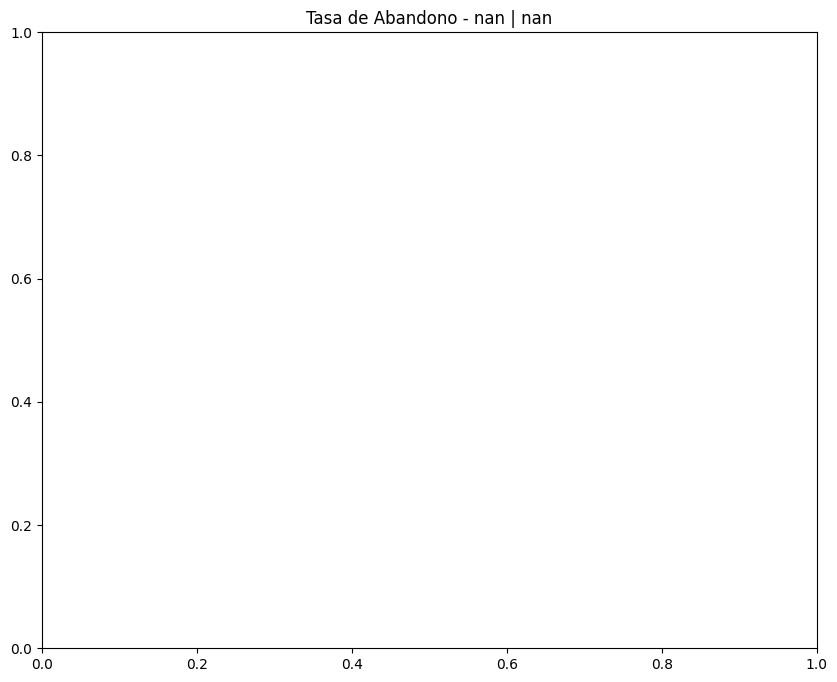

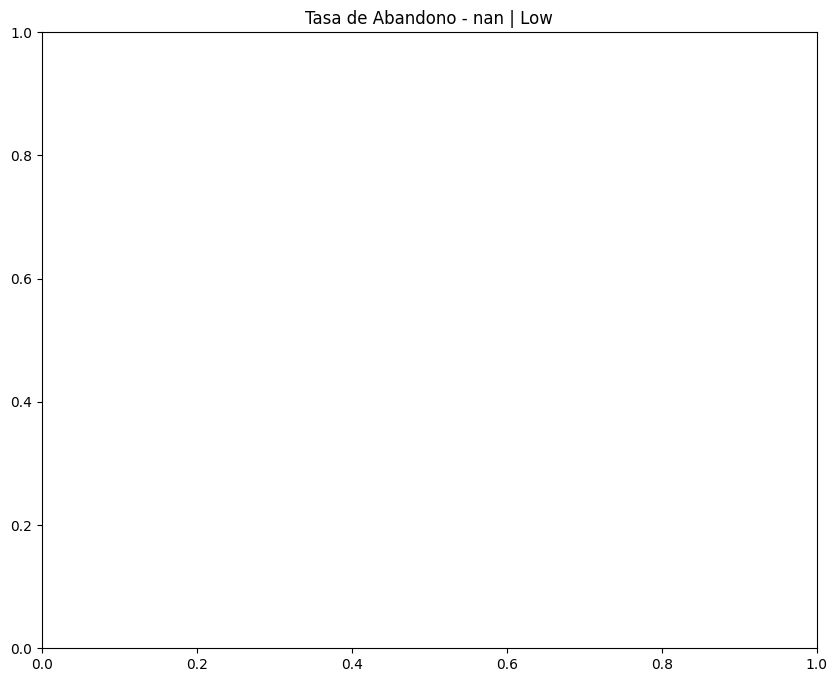

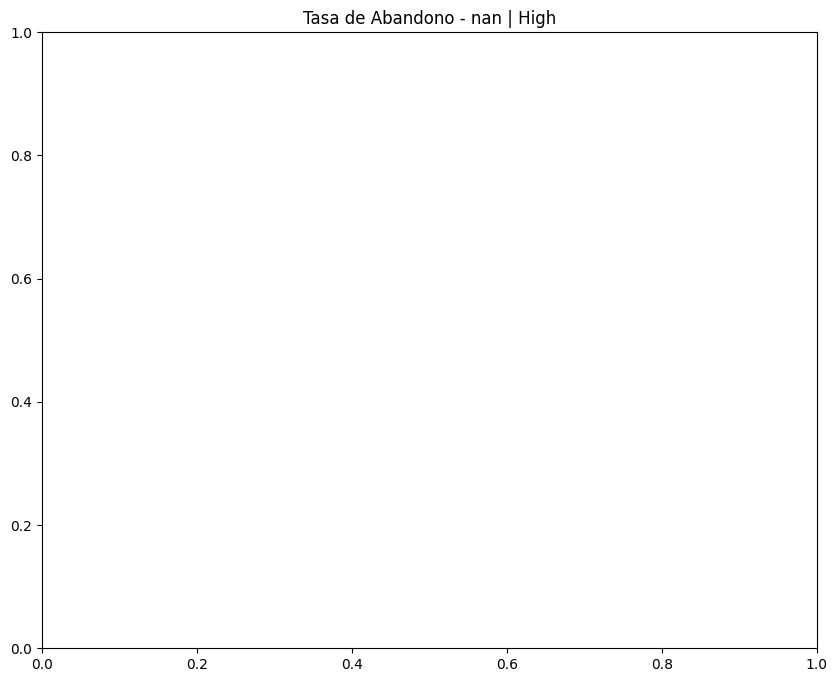

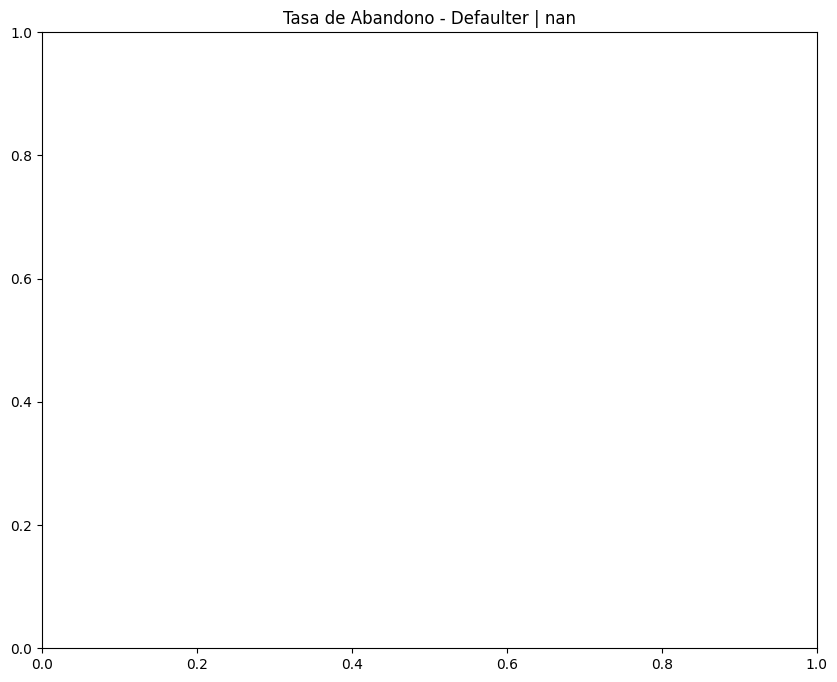

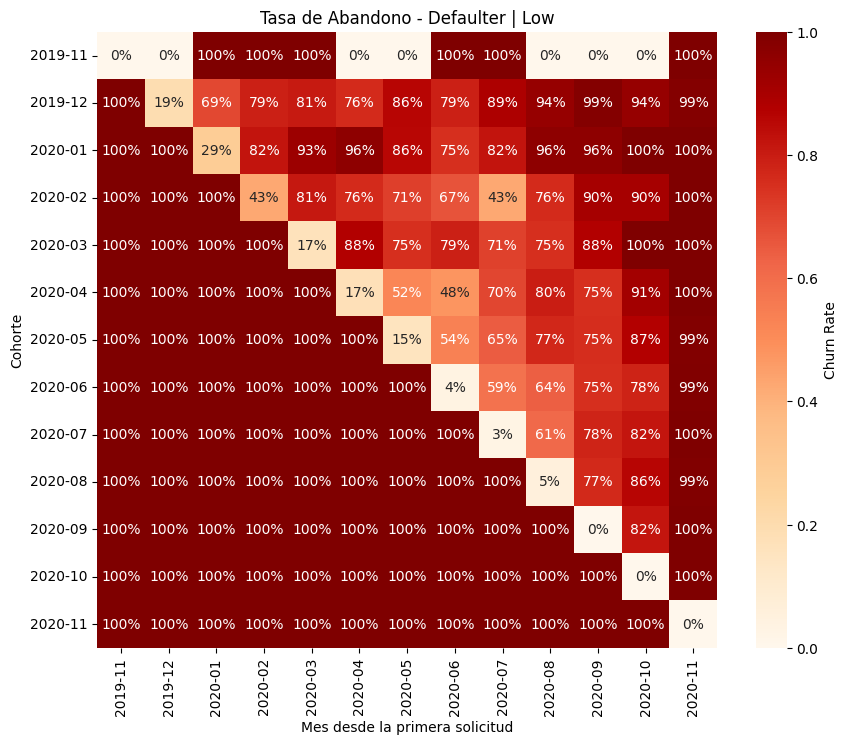

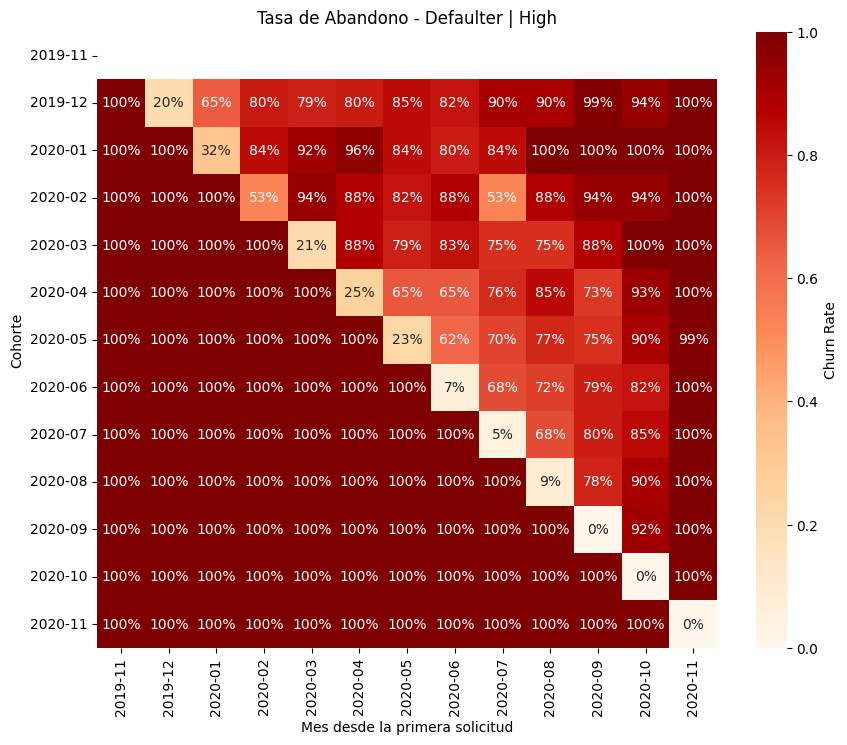

No hay datos para On-time Payer | nan


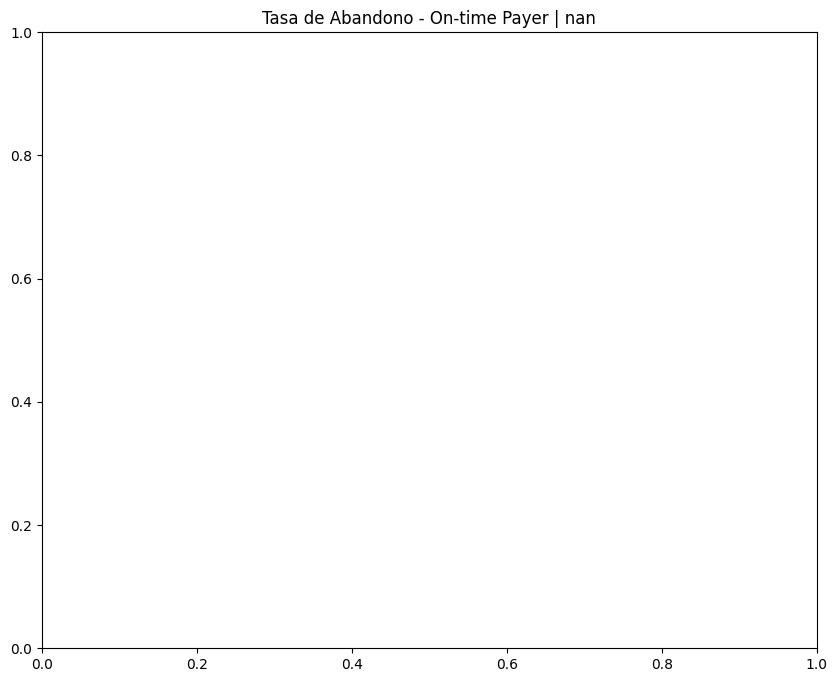

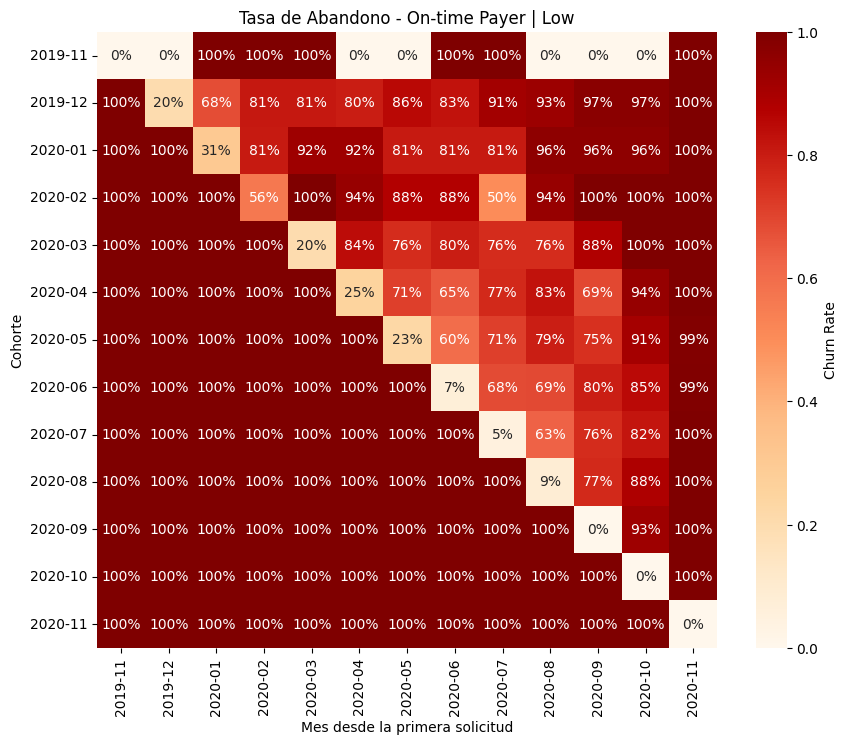

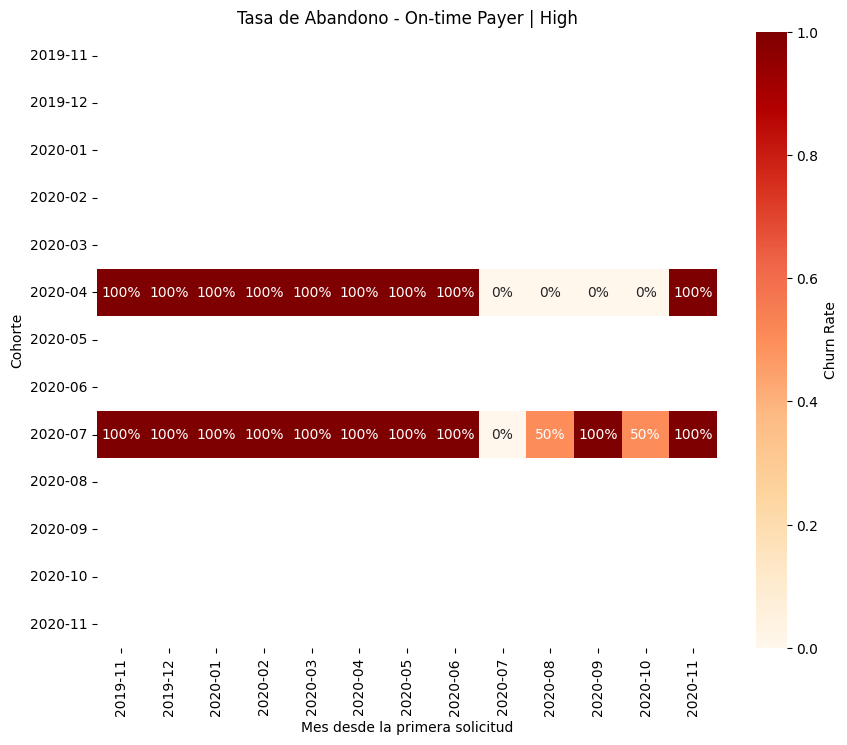

No hay datos para Late Payer | nan


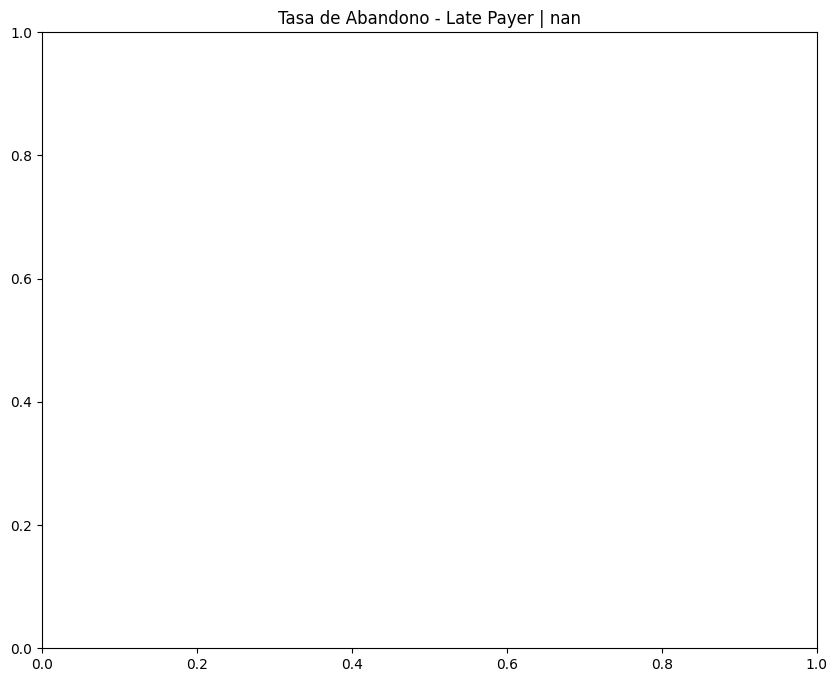

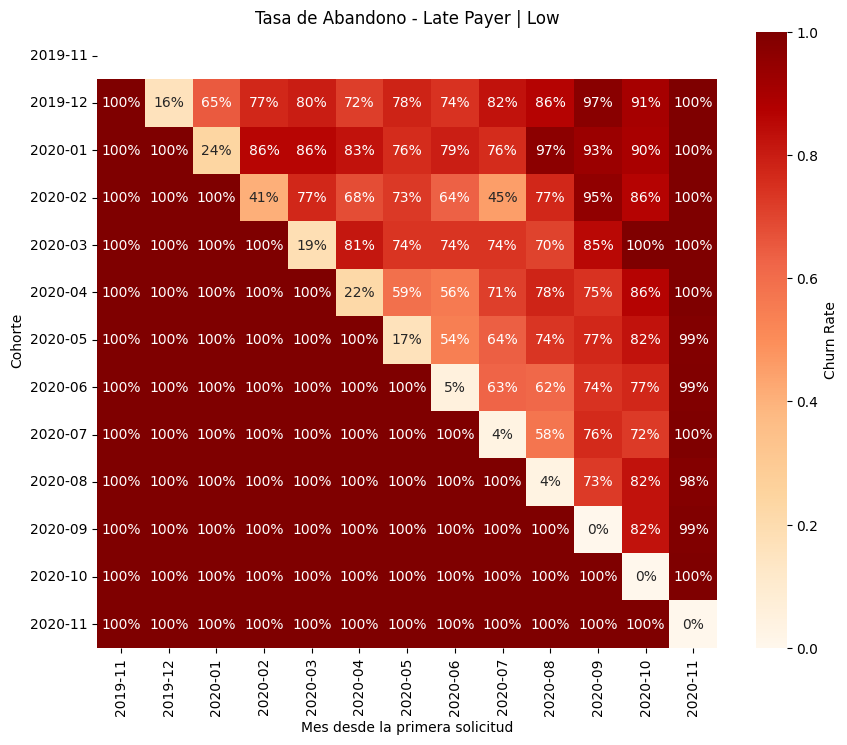

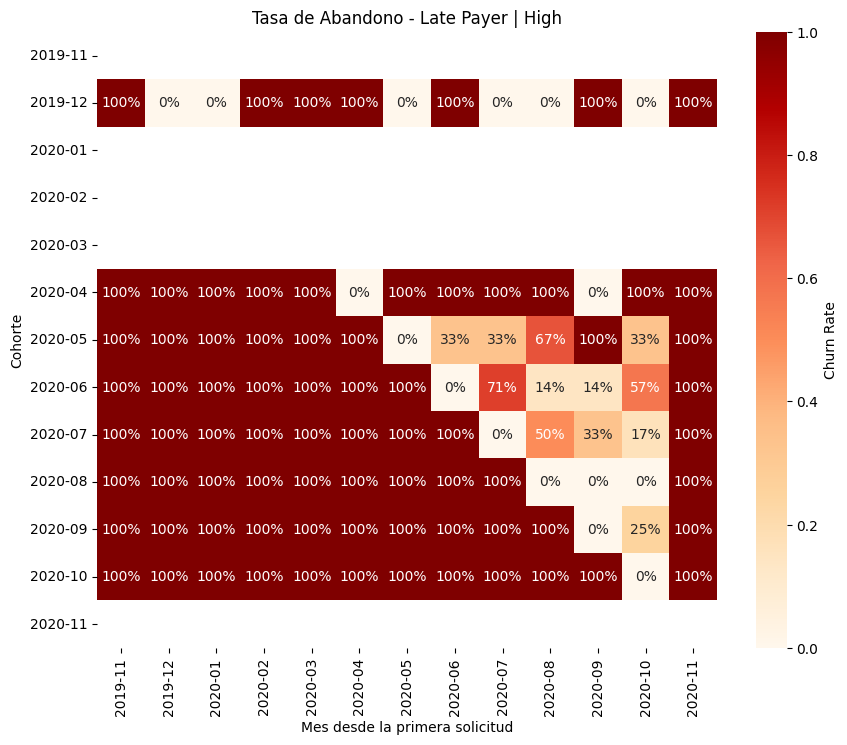

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# **Calcular la tasa de abandono (Churn Rate)**
churn_rate = 1 - customers_retention

# **Generar Heatmaps de Abandono por Segmento**
for segment in merged_data['Repayment_Status'].unique():
    for rejection in merged_data['fees_rejection_segment'].unique():
        try:
            plt.figure(figsize=(10, 8))
            plt.title(f'Tasa de Abandono - {segment} | {rejection}')
            sns.heatmap(data=churn_rate.xs((segment, rejection), level=[1, 2]),
                        annot=True,
                        fmt='.0%',
                        vmin=0.0,
                        vmax=1.0,
                        cmap='OrRd',  # Colores cálidos para abandono
                        cbar_kws={'label': 'Churn Rate'})
            plt.xlabel('Mes desde la primera solicitud')
            plt.ylabel('Cohorte')
            plt.show()
        except KeyError:
            print(f"No hay datos para {segment} | {rejection}")
